In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#PDFs in BDT and sindec?
import os

# set env flags to catch BLAS used for scipy/numpy 
# to only use 1 cpu, n_cpus will be totally controlled by csky
os.environ['MKL_NUM_THREADS'] = "1"
os.environ['NUMEXPR_NUM_THREADS'] = "1"
os.environ['OMP_NUM_THREADS'] = "1"
os.environ['OPENBLAS_NUM_THREADS'] = "1"
os.environ['VECLIB_MAXIMUM_THREADS'] = "1"

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['savefig.facecolor'] = 'w'
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import csky as cy
from csky import cext
import numpy as np
import pandas as pd
import astropy
#from icecube import astro
import histlite as hl
import healpy
import socket
import pickle
import copy
healpy.disable_warnings()
plt.rc('figure', facecolor = 'w')
plt.rc('figure', dpi=100)

## Define Settings

In [2]:
selection_version = 'version-001-p00'

host_name = socket.gethostname()

if 'cobalt' in host_name:
    print('Working on Cobalts')
    data_prefix = '/data/user/ssclafani/data/cscd/final'
    ana_dir = '/data/user/ssclafani/data/analyses/'
    plot_dir = '/home/mhuennefeld/public_html/analyses/DNNCascade/plots/review/dec_randomizer_checks'
    
elif 'phobos' in host_name:
    print('Working on Phobos')
    data_prefix = '/net/big-tank/POOL/users/mhuennefeld/analyses/DNNCascade/data/cscd/final'
    ana_dir = '/net/big-tank/POOL/users/mhuennefeld/analyses/DNNCascade/csky/analyses/'
    plot_dir = '/home/mhuennefeld/analyses/DNNCascade/plots/review/dec_randomizer_checks'
    
else:
    raise ValueError('Unknown host:', host_name)

Working on Cobalts


In [3]:
for dir_path in [plot_dir]:
    if not os.path.exists(dir_path):
        print('Creating directory:', dir_path)
        os.makedirs(dir_path)

## Load Data

In [4]:
repo = cy.selections.Repository()
specs = cy.selections.DNNCascadeDataSpecs.DNNC_10yr

In [5]:
class DNNCascade_10yr_mc_weights(cy.selections.DNNCascadeDataSpecs.DNNCascade_10yr):
    def dataset_modifications(self, ds):
        print('Adding weights to MC')
        path_sig_df = (
            '/data/ana/PointSource/DNNCascade/analysis/' + 
            self._path_sig.format(version=self._version).replace('dnn_cascades/', '').replace('.npy', '.hdf')
        )
        df = pd.read_hdf(path_sig_df, key='df')
        assert np.allclose(df['run'], ds.sig.run)
        assert np.allclose(df['energy'], ds.sig.energy)
        assert np.allclose(df['ow'], ds.sig.oneweight)
        for k in df.keys():
            if 'weight' in k or 'veto' in k:
                ds.sig[k] = df[k]

specs = [DNNCascade_10yr_mc_weights]

In [6]:
%%time

ana = cy.get_analysis(
    repo, selection_version, specs, 
    #gammas=np.r_[0.1:6.01:0.125],
)

Setting up Analysis for:
DNNCascade_10yr_mc_weights
Setting up DNNCascade_10yr_mc_weights...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/ve

In [7]:
a = ana.anas[0]
a.sig

Events(398873 items | columns: azimuth, dec, energy, event, log10energy, mjd, nuveto_pf_dnn_cascade_selection_H3a_SIBYLL2_3c_conv, nuveto_pf_dnn_cascade_selection_H3a_SIBYLL2_3c_pr, nuveto_pf_dnn_cascade_selection_H3a_SIBYLL2_3c_total, ra, run, sigma, sindec, subevent, weights, weights_MCEq_H3a_sibyll2_3c_conv, weights_MCEq_H3a_sibyll2_3c_pr, weights_MCEq_H3a_sibyll2_3c_total, weights_aachen_flux, weights_aachen_flux_8yr, weights_cscd_hans, weights_cscd_icrc15, weights_global_fit, weights_hese4_bestfit, weights_hese4_fixed, weights_hese6, weights_hese_flux, weights_livetime, weights_mese_flux, weights_meta_info_n_events_per_run, weights_meta_info_n_files, xdec, xra, true_dec, true_energy, true_ra, oneweight)

In [8]:
a.bg_data

Events(59610 items | columns: azimuth, dec, energy, event, log10energy, mjd, ra, run, sigma, sindec, subevent)

## Helper Functions

In [30]:
from cycler import cycle
from copy import deepcopy

soft_colors = cy.plotting.soft_colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

DEFAULT_CONF_KWARGS = {
    'dec_rand_kwargs' : dict(randomization_width = np.radians(3)),
    'dec_rand_method' : 'gaussian_fixed',
    'dec_rand_pole_exlusion' : np.radians(8),
    'bg_replace': True,
}

def get_color_cycler():
    return cycle(colors) 

def get_trial_runner(sindec, gamma, ana, cpus, ra=0., cutoff_TeV=np.inf, sigsub=True, conf_kwargs=DEFAULT_CONF_KWARGS):
    src = cy.utils.sources(ra, np.arcsin(sindec), deg=False)
    cutoff_GeV = cutoff_TeV * 1e3
    conf = {
        'src' : src, 
        'flux' : cy.hyp.PowerLawFlux(gamma, energy_cutoff = cutoff_GeV),
        'update_bg': True,
        'sigsub' :  sigsub,
        'randomize' : ['ra', cy.inj.DecRandomizer],
        'sindec_bandwidth' : np.radians(5),
        'cut_n_sigma': 100, #---------------------------new
        **conf_kwargs,
    }
    tr = cy.get_trial_runner(ana=ana, conf= conf, mp_cpus=cpus)
    return tr, src

def get_trial_runner_sindec_jitter(sindec, gamma, ana, cpus, ra=0., cutoff_TeV=np.inf, sigsub=True, conf_kwargs=DEFAULT_CONF_KWARGS):
    src = cy.utils.sources(ra, np.arcsin(sindec), deg=False)
    cutoff_GeV = cutoff_TeV * 1e3
    conf = {
        'src' : src, 
        'flux' : cy.hyp.PowerLawFlux(gamma, energy_cutoff = cutoff_GeV),
        'update_bg': True,
        'sigsub' :  sigsub,
        'randomize' : ['ra', cy.inj.SinDecRandomizer],
        'sindec_bandwidth' : np.radians(5),
        'cut_n_sigma': 100, #---------------------------new
        **conf_kwargs,
    }
    tr = cy.get_trial_runner(ana=ana, conf= conf, mp_cpus=cpus)
    return tr, src

def get_trial_runner_no_sigsub(*args, **kwargs):
    if 'sigsub' in kwargs: raise KeyError('sigsub is defined!')
    return get_trial_runner(*args, sigsub=False, **kwargs)

def get_bkg_injector(sindec, gamma, ana, cpus=20, sigsub=True, cutoff_TeV=np.inf, conf_kwargs=DEFAULT_CONF_KWARGS, tr_func=get_trial_runner):
    
    # get trial runner
    trial_runner, src = tr_func(
        sindec, ra=0., gamma=gamma, ana=ana, sigsub=sigsub, cpus=cpus, cutoff_TeV=cutoff_TeV, conf_kwargs=conf_kwargs)
    assert len(trial_runner.bg_injs) == 1
    return trial_runner.bg_injs[0]

def get_sig_injector(sindec, gamma, ana, cpus=20, sigsub=True, cutoff_TeV=np.inf, conf_kwargs=DEFAULT_CONF_KWARGS, tr_func=get_trial_runner):
    
    bkg_inj = get_bkg_injector(sindec=sindec, gamma=gamma, ana=ana, cpus=cpus, sigsub=sigsub, cutoff_TeV=cutoff_TeV, conf_kwargs=conf_kwargs, tr_func=tr_func)
    
    sig_inj = cy.inj.DataInjector(
        ana=bkg_inj.ana,
        data=a.sig,
        keep=a.sig.keys(),
        randomizers=bkg_inj.randomizers,
    )
    return sig_inj

def get_bkg_scramble(sindec, gamma, ana, cpus=20, sigsub=True, cutoff_TeV=np.inf, conf_kwargs=DEFAULT_CONF_KWARGS, tr_func=get_trial_runner, seed=None):
    bkg_inj = get_bkg_injector(
        sindec=sindec, gamma=gamma, ana=ana, cpus=cpus, sigsub=sigsub, cutoff_TeV=cutoff_TeV, conf_kwargs=conf_kwargs, tr_func=tr_func,
    )
    [out], n_excluded = bkg_inj.inject(seed=seed)
    if n_excluded > 0:
        print('n_excluded:', n_excluded)
    return out

def get_sig_scramble(sindec, gamma, ana, cpus=20, sigsub=True, cutoff_TeV=np.inf, conf_kwargs=DEFAULT_CONF_KWARGS, tr_func=get_trial_runner, seed=None):
    sig_inj = get_sig_injector(
        sindec=sindec, gamma=gamma, ana=ana, cpus=cpus, sigsub=sigsub, cutoff_TeV=cutoff_TeV, conf_kwargs=conf_kwargs, tr_func=tr_func,
    )
    [out], n_excluded = sig_inj.inject(seed=seed)
    if n_excluded > 0:
        print('n_excluded:', n_excluded)
    return out


def plot_scramble_distribution(
            key, 
            key_cond,
            bins,
            cond_mids,
            cond_width,
            sig=False,
            n_scrambles=10,
            axes_dim=(3, 3),
            fig=None, axes=None, 
            figsize=(12, 12),
            label='{} bg trials', 
            label_fit_median=r'$\chi^2[{:.2f}$ dof $\eta={:.3f}]$ | Median', 
            label_fit=r'$\chi^2[{:.2f}$ dof $\eta={:.3f}]$ | Sample {}', 
            color=colors[0],
            conf_kwargs=DEFAULT_CONF_KWARGS,
            tr_func=get_trial_runner,
            mask_func=None,
        ):
    
    assert np.prod(axes_dim) == len(cond_mids)
    
    if axes is None:
        fig, axes = plt.subplots(*axes_dim, sharex=True, figsize=figsize)
    axes_flat = axes.flatten()
    
    def get_mask(df, cond_mid):
        
        mask = np.logical_and(
            df[key_cond] >= cond_mid - cond_width,
            df[key_cond] < cond_mid + cond_width,
        )
        if mask_func is not None:
            mask = np.logical_and(mask, mask_func(df))
        return mask
    
    if sig:
        scramble_func = get_sig_scramble
        df = a.sig
        data_label = 'MC'
    else:
        scramble_func = get_bkg_scramble
        df = a.bg_data
        data_label = 'Data'
    
    for i, cond_mid in enumerate(cond_mids):
        
        ax = axes_flat[i]
        
        # plot hist of bkg data
        mask = get_mask(df, cond_mid)
        
        if sig:
            h_data = hl.hist(df[key][mask], bins=bins, weights=df.weights[mask]).normalize()
        else:
            h_data = hl.hist(df[key][mask], bins=bins).normalize()
        
        hl.plot1d(ax, h_data, color=colors[0], lw=2, drawstyle='default')
        hl.plot1d(ax, h_data, crosses=True, color=colors[0], lw=2, drawstyle='default', label=data_label)
        
        # create scrambles
        h_scrambles = []
        for j in range(n_scrambles):
            df_j = scramble_func(
                sindec=0.,
                gamma=2.5,
                ana=ana,
                cpus=1,
                seed=j,
                conf_kwargs=conf_kwargs,
                tr_func=tr_func,
            )
            mask = get_mask(df_j, cond_mid)
            if sig:
                h_scrambles.append(hl.hist(df_j[key][mask], bins=bins, weights=df_j.weights[mask]).normalize())
            else:
                h_scrambles.append(hl.hist(df_j[key][mask], bins=bins).normalize())
    
        # get median values
        hs_values = np.array([h.values for h in h_scrambles])
        h_median = hl.Hist(bins=bins, values=np.median(hs_values, axis=0))
        h_min = hl.Hist(bins=bins, values=np.min(hs_values, axis=0))
        h_max = hl.Hist(bins=bins, values=np.max(hs_values, axis=0))
    
        # plot range
        hl.fill_between(ax, h_min, h_max, color=colors[1], alpha=.3, drawstyle='line')
        hl.plot1d (ax, h_median, color=colors[1], ls='--', lw=2, drawstyle='default')
        hl.plot1d(ax, h_median, crosses=True, color=colors[1], label='Scrambles')
    
        ax.set_xlabel(key)
        ax.set_ylabel(r'Density')
        ax.set_title('{} = {:3.3f} $\pm$ {:3.3f}'.format(key_cond, cond_mid, cond_width))
        ax.legend()
        ax.set_yscale('log')
        
    fig.tight_layout()
    return fig, ax


## Sigma PDF

/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


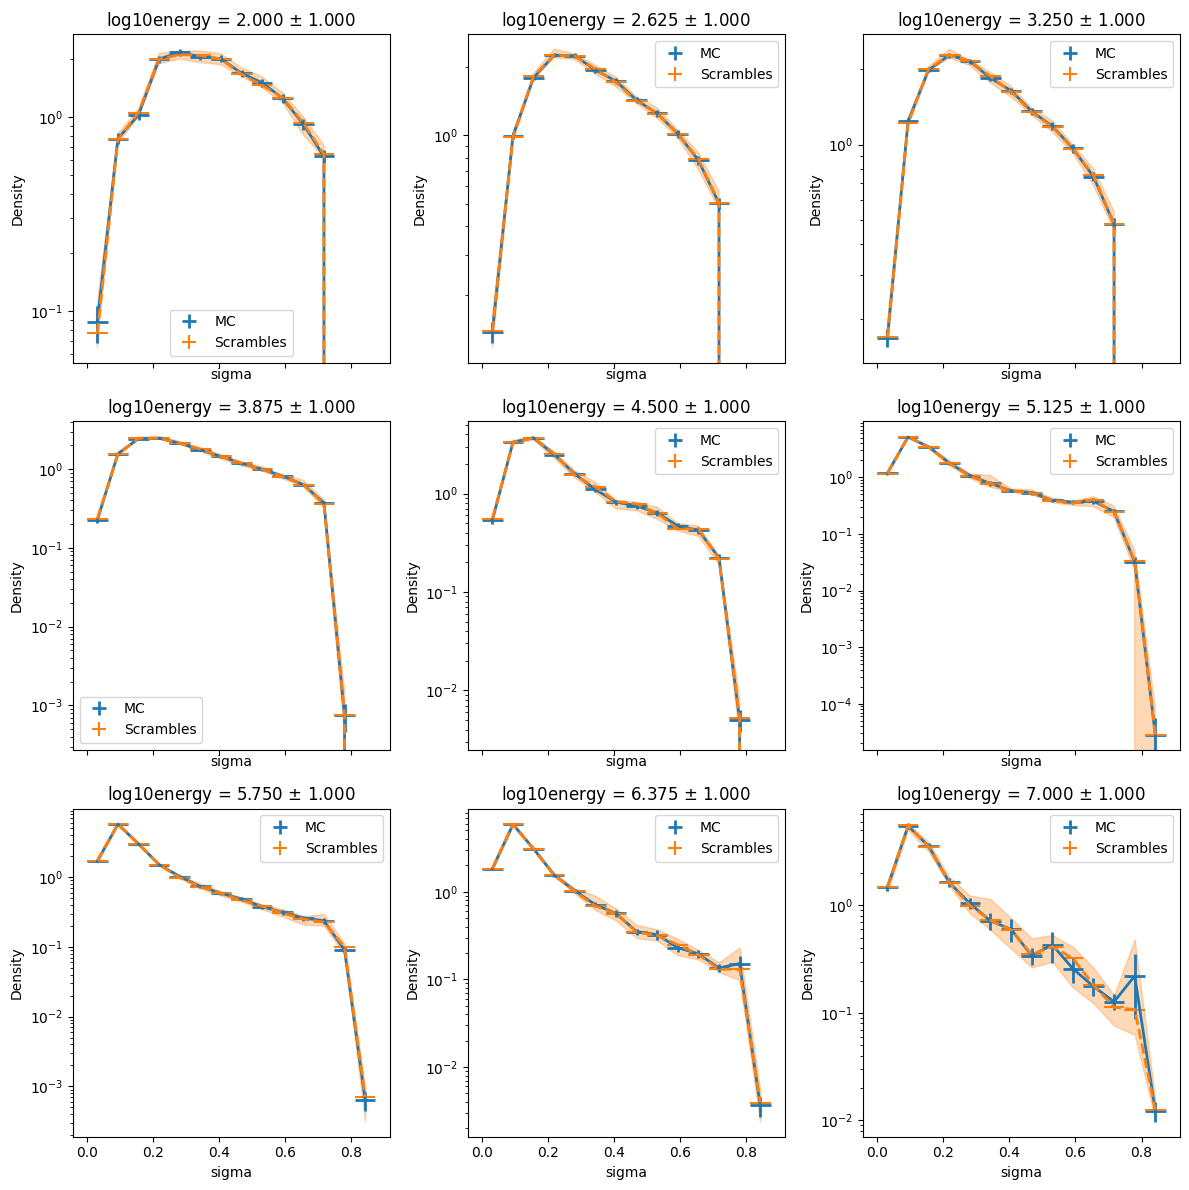

In [28]:
rand_width = np.deg2rad(3)
sig = True
fig, axes = plot_scramble_distribution(
    key='sigma', 
    key_cond='log10energy',
    bins=np.linspace(0, np.deg2rad(50), 15),
    cond_mids=np.linspace(2, 7, 9),
    cond_width=1.,
    conf_kwargs=get_conf(randomization_width=rand_width),
    sig=sig,
)
fig.tight_layout()
fig.savefig(os.path.join(plot_dir, 'scramble_dist_sigma_{}_sindec_width_{:3.1f}.png'.format(sig, np.rad2deg(rand_width))))
    

## Make Plots

In [31]:
from copy import deepcopy

rand_widths = np.deg2rad([3, 5, 8, 15])

def get_conf(randomization_width):
    conf = deepcopy(DEFAULT_CONF_KWARGS)
    conf['dec_rand_kwargs']['randomization_width'] = randomization_width
    return conf


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


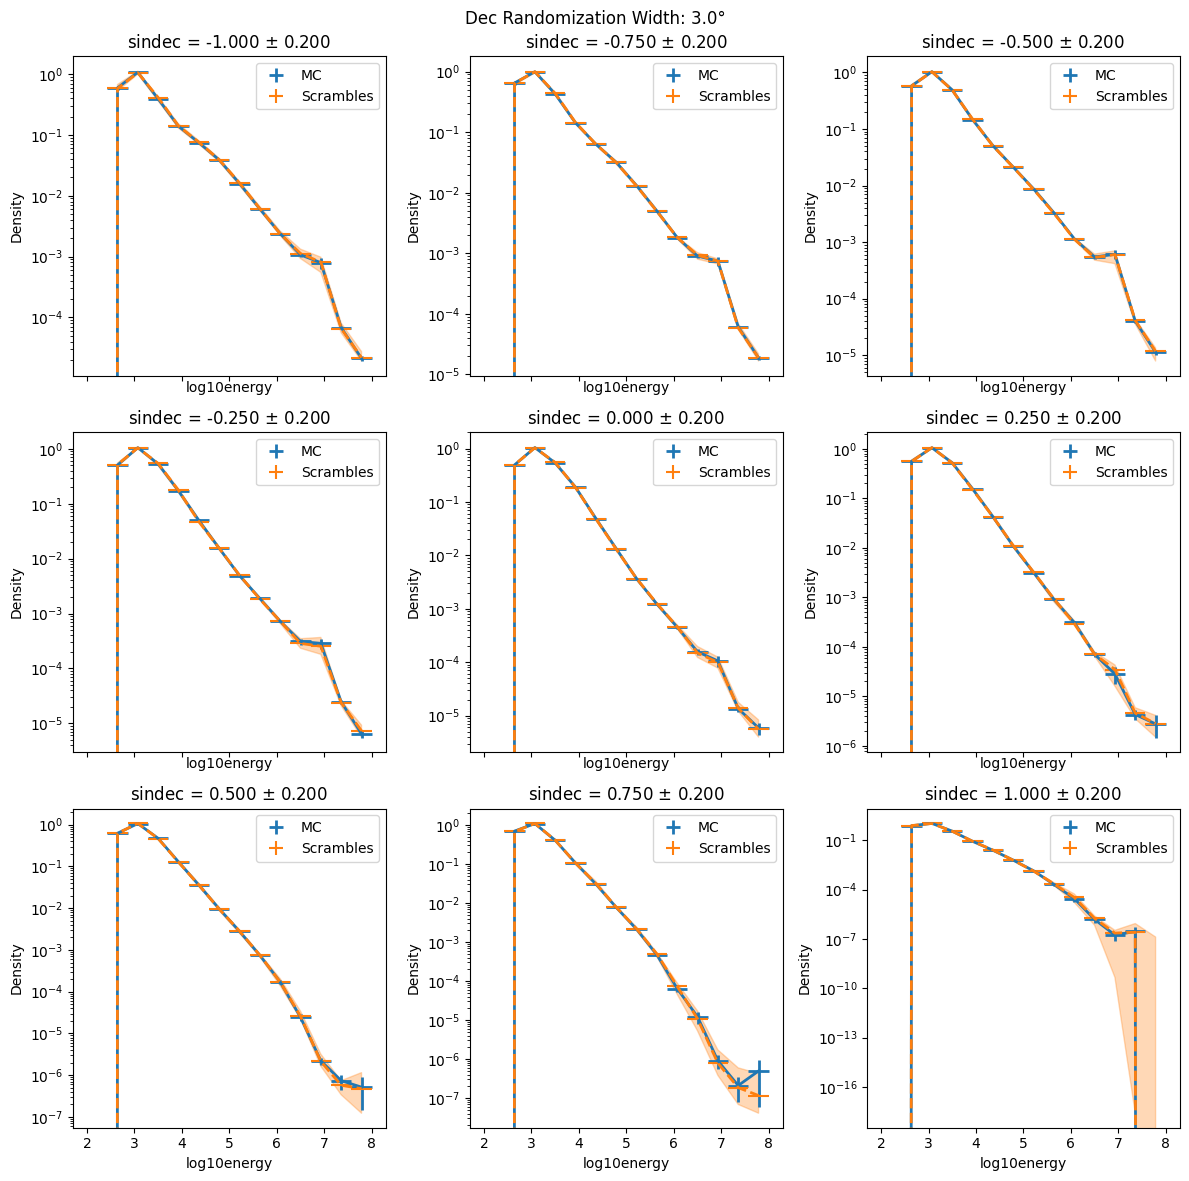

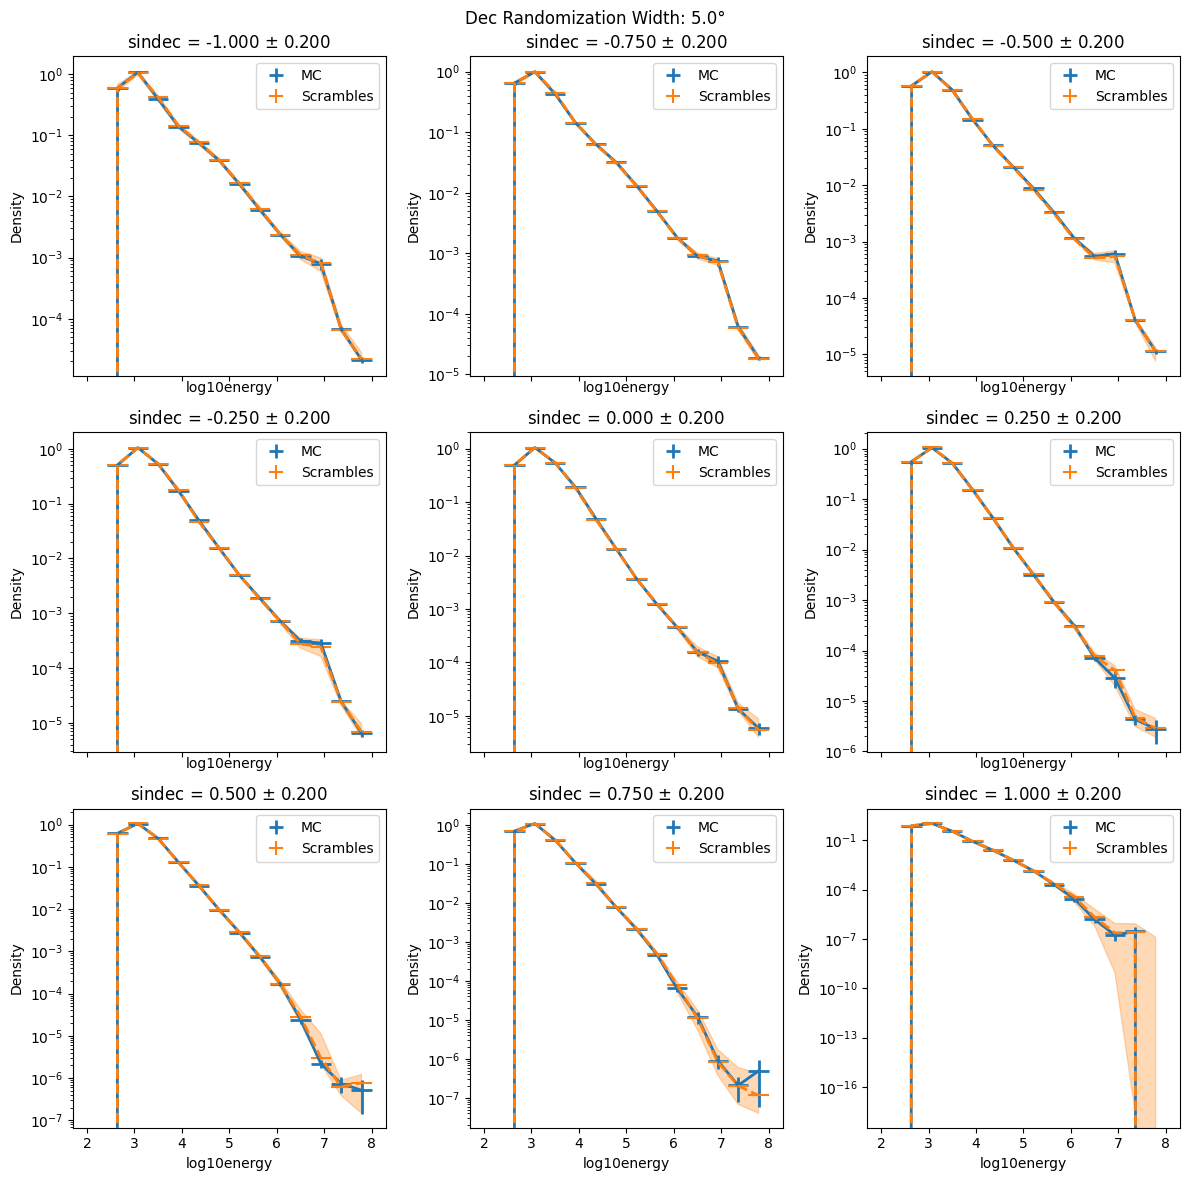

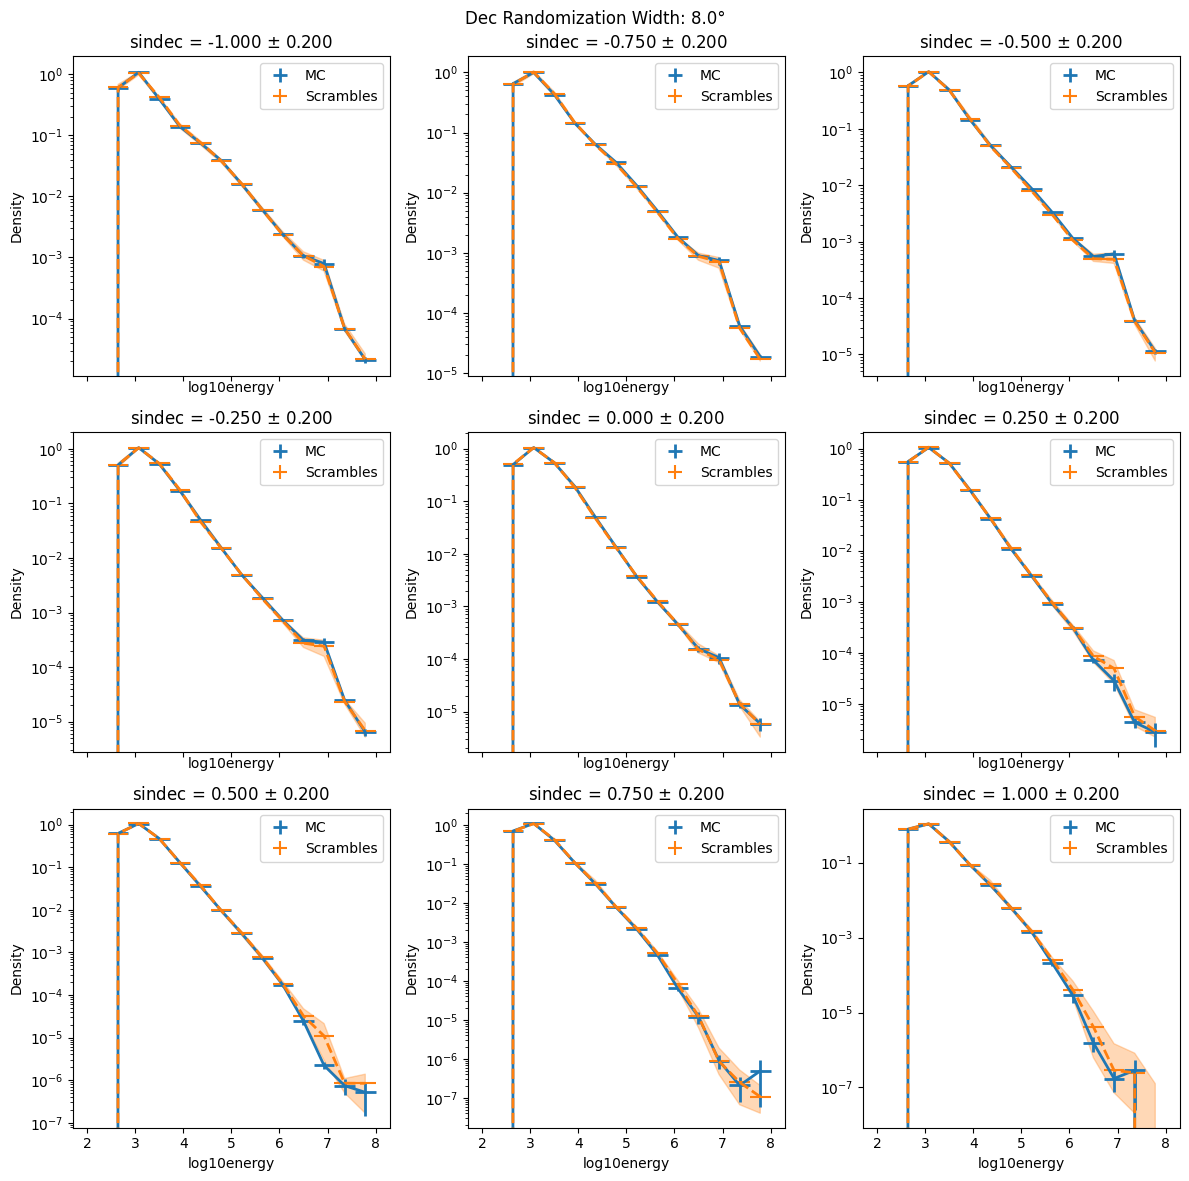

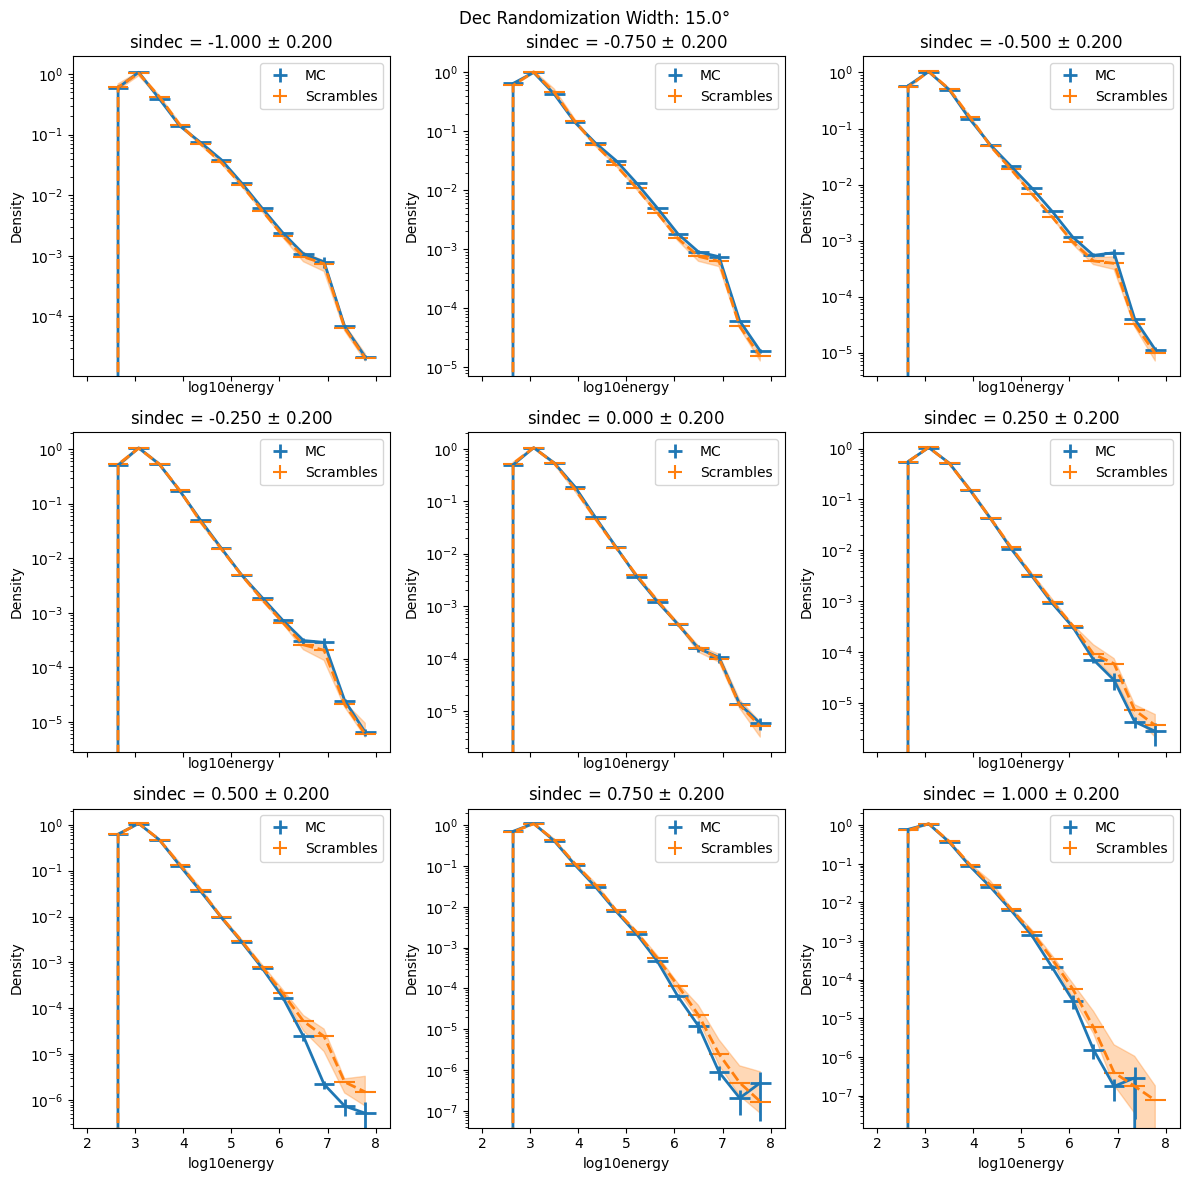

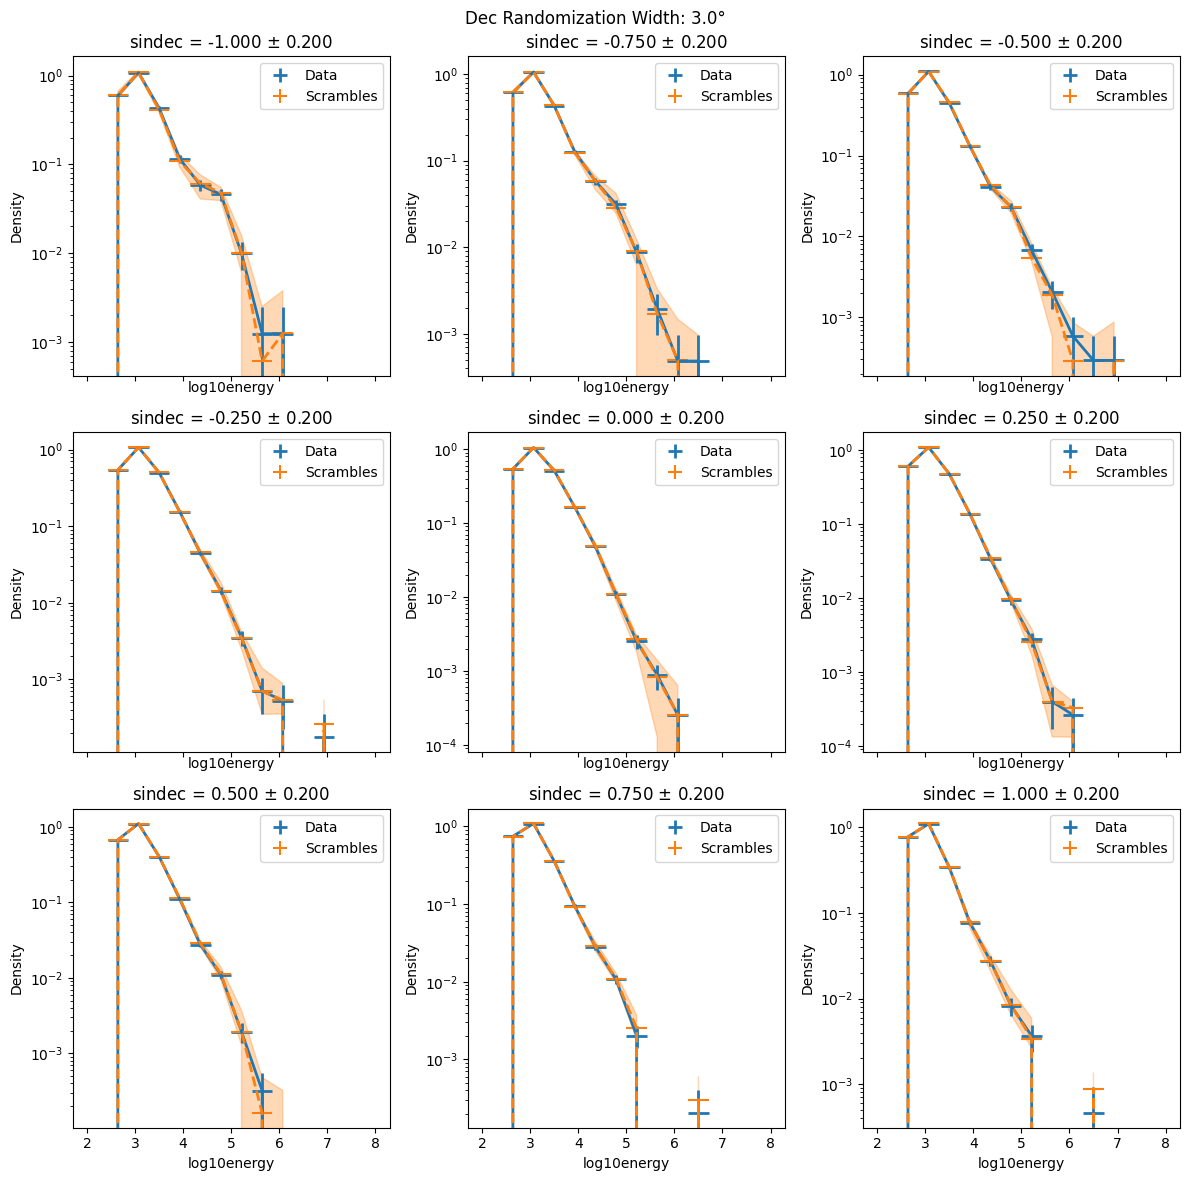

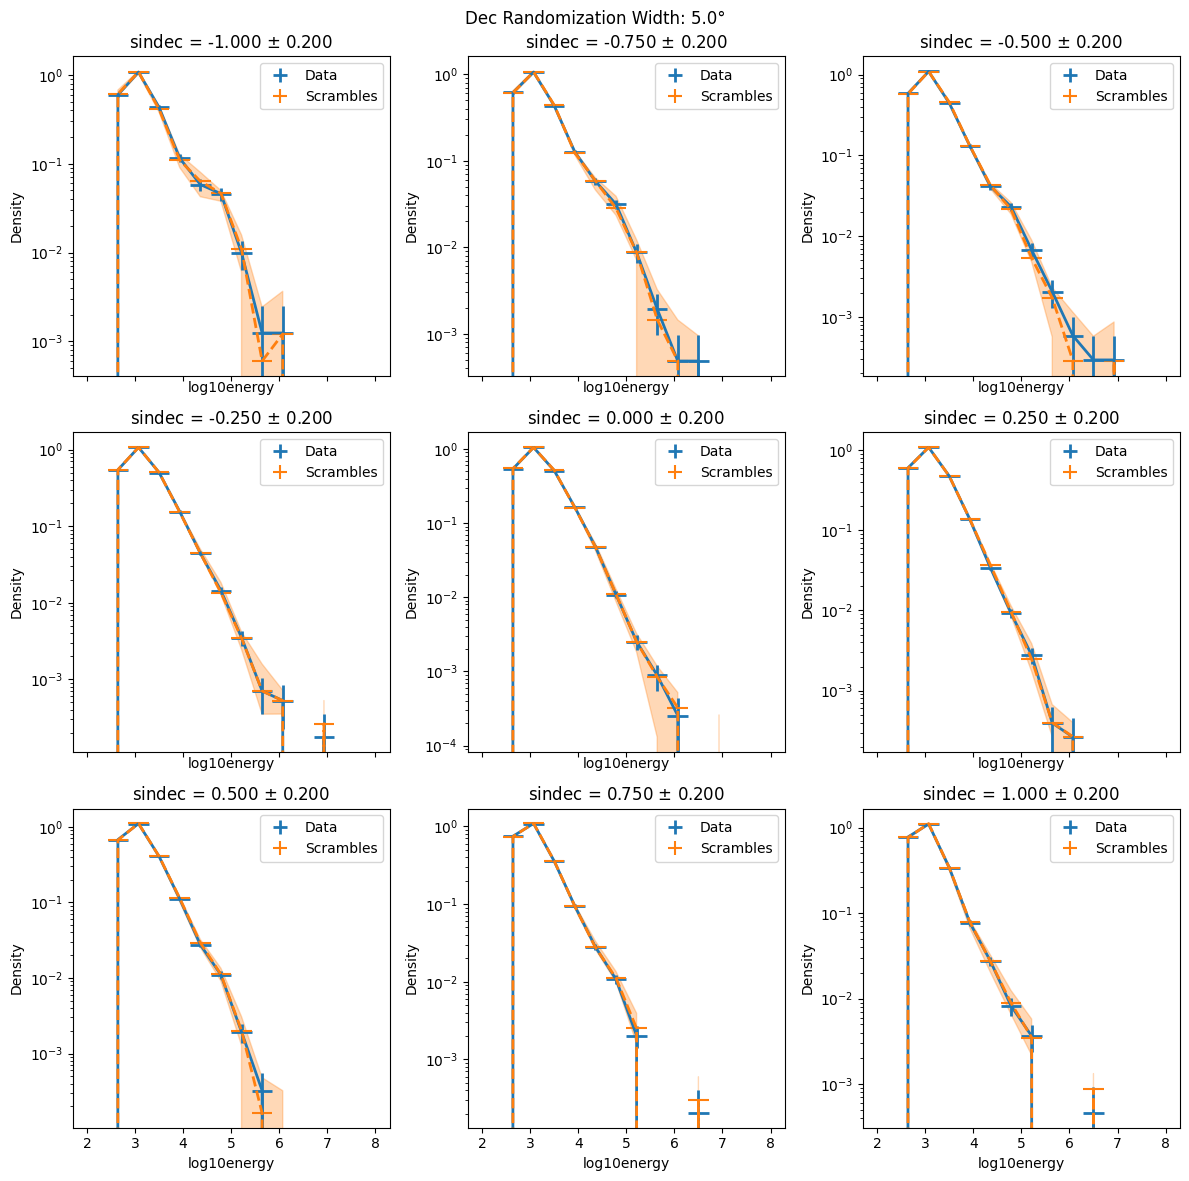

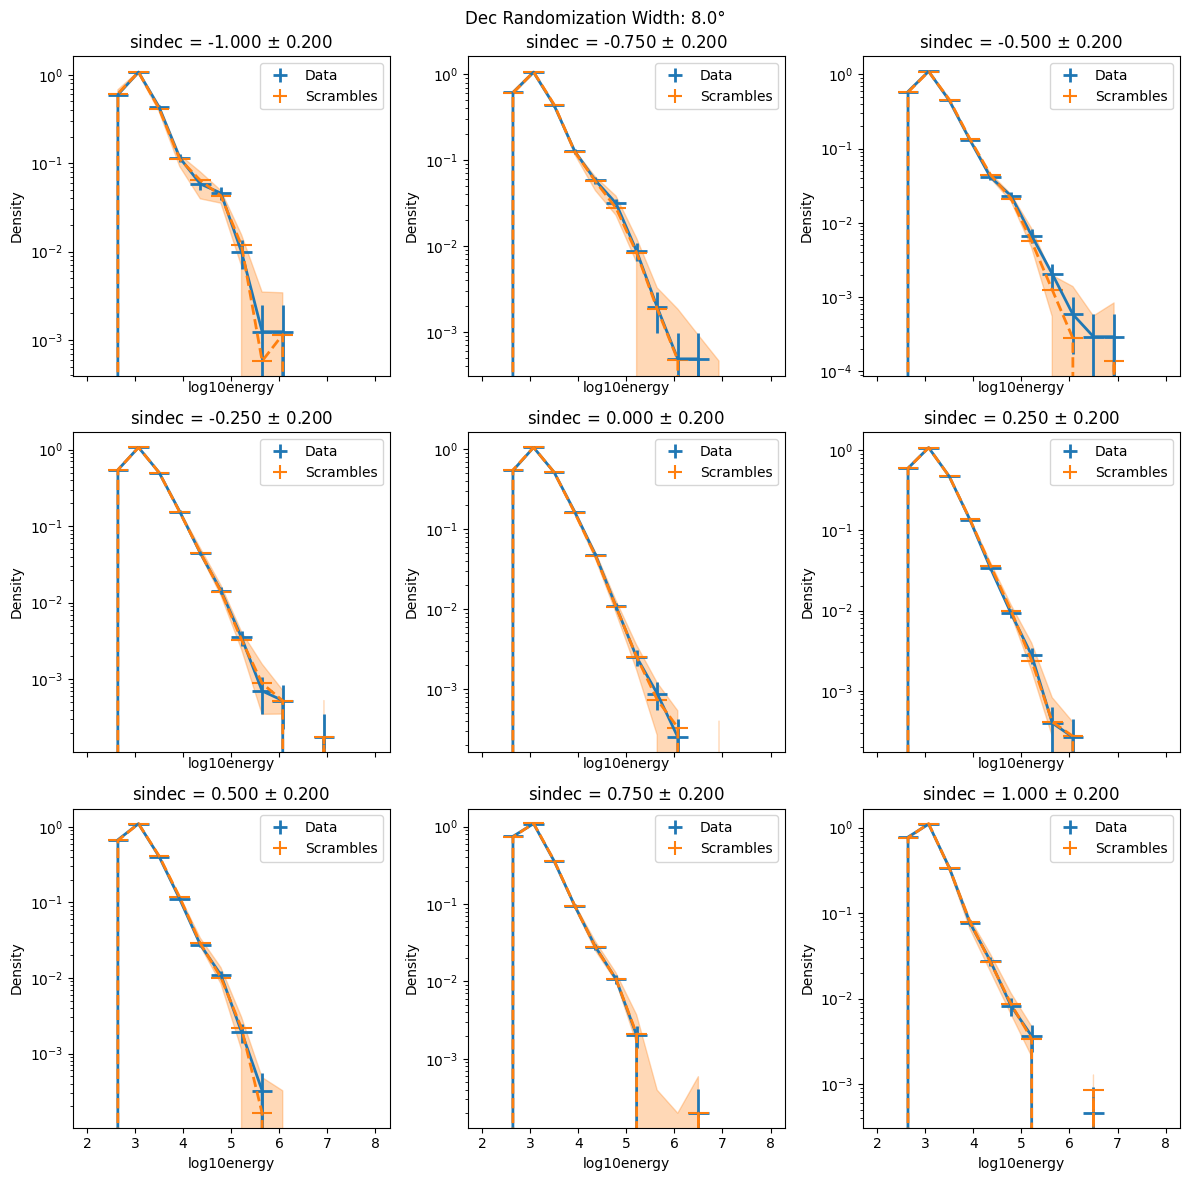

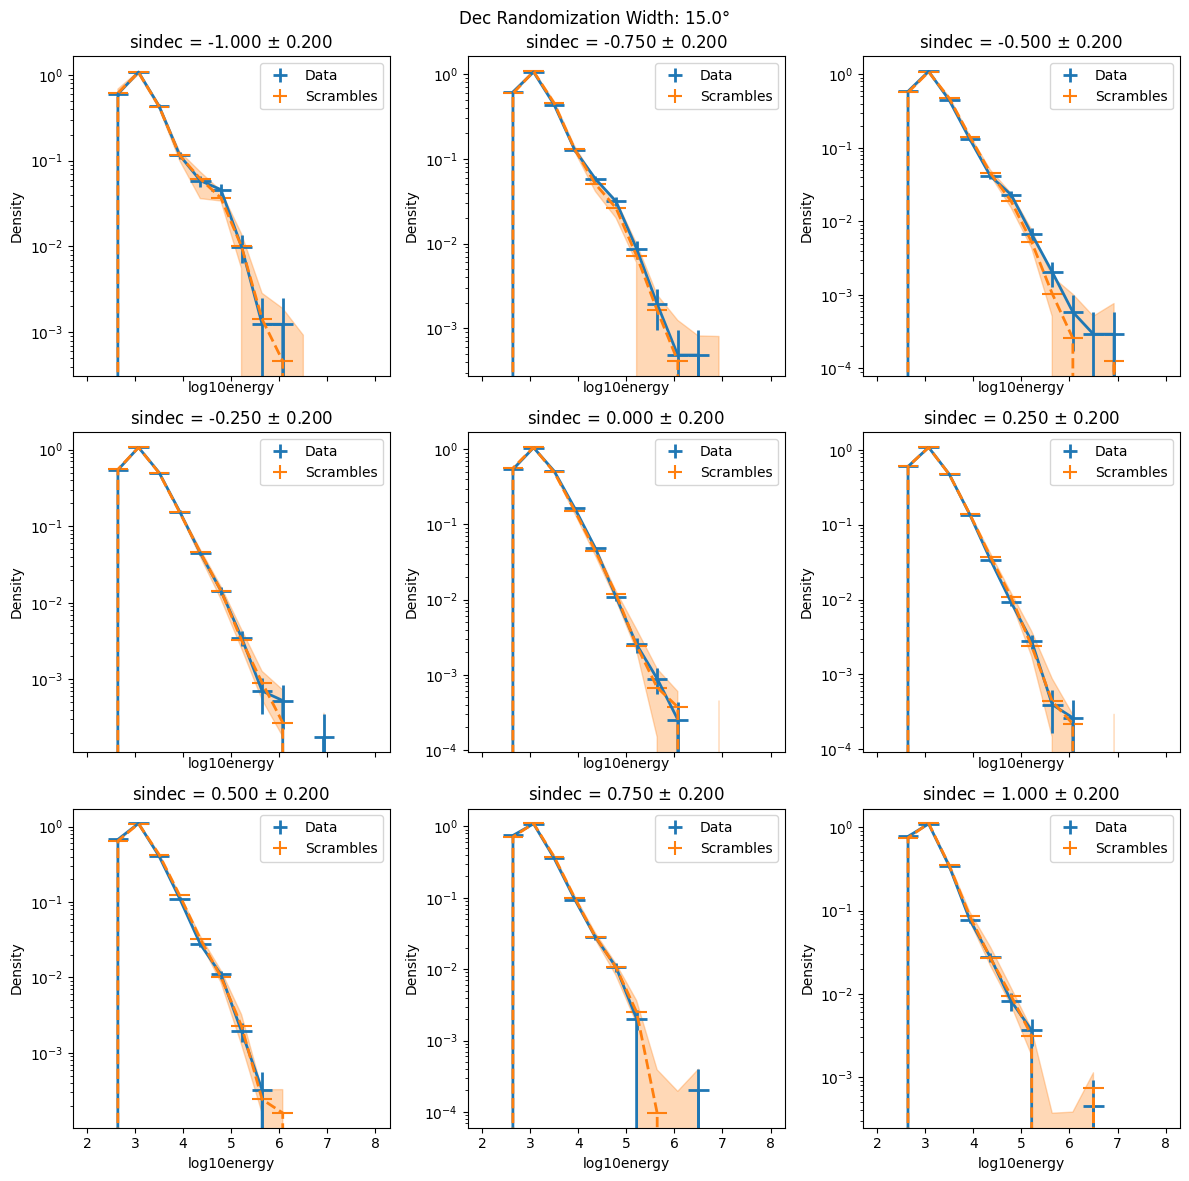

In [16]:
for sig in [True, False]:
    for rand_width in rand_widths:
        fig, axes = plot_scramble_distribution(
            key='log10energy', 
            key_cond='sindec',
            bins=np.linspace(2, 8, 15),
            cond_mids=np.linspace(-1, 1, 9),
            cond_width=0.2,
            conf_kwargs=get_conf(randomization_width=rand_width),
            sig=sig,
        )
        fig.suptitle('Dec Randomization Width: {:3.1f}°'.format(np.rad2deg(rand_width)))
        fig.tight_layout()
        fig.savefig(os.path.join(plot_dir, 'scramble_dist_log10energy_{}_sindec_width_{:3.1f}.png'.format(sig, np.rad2deg(rand_width))))
    

/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


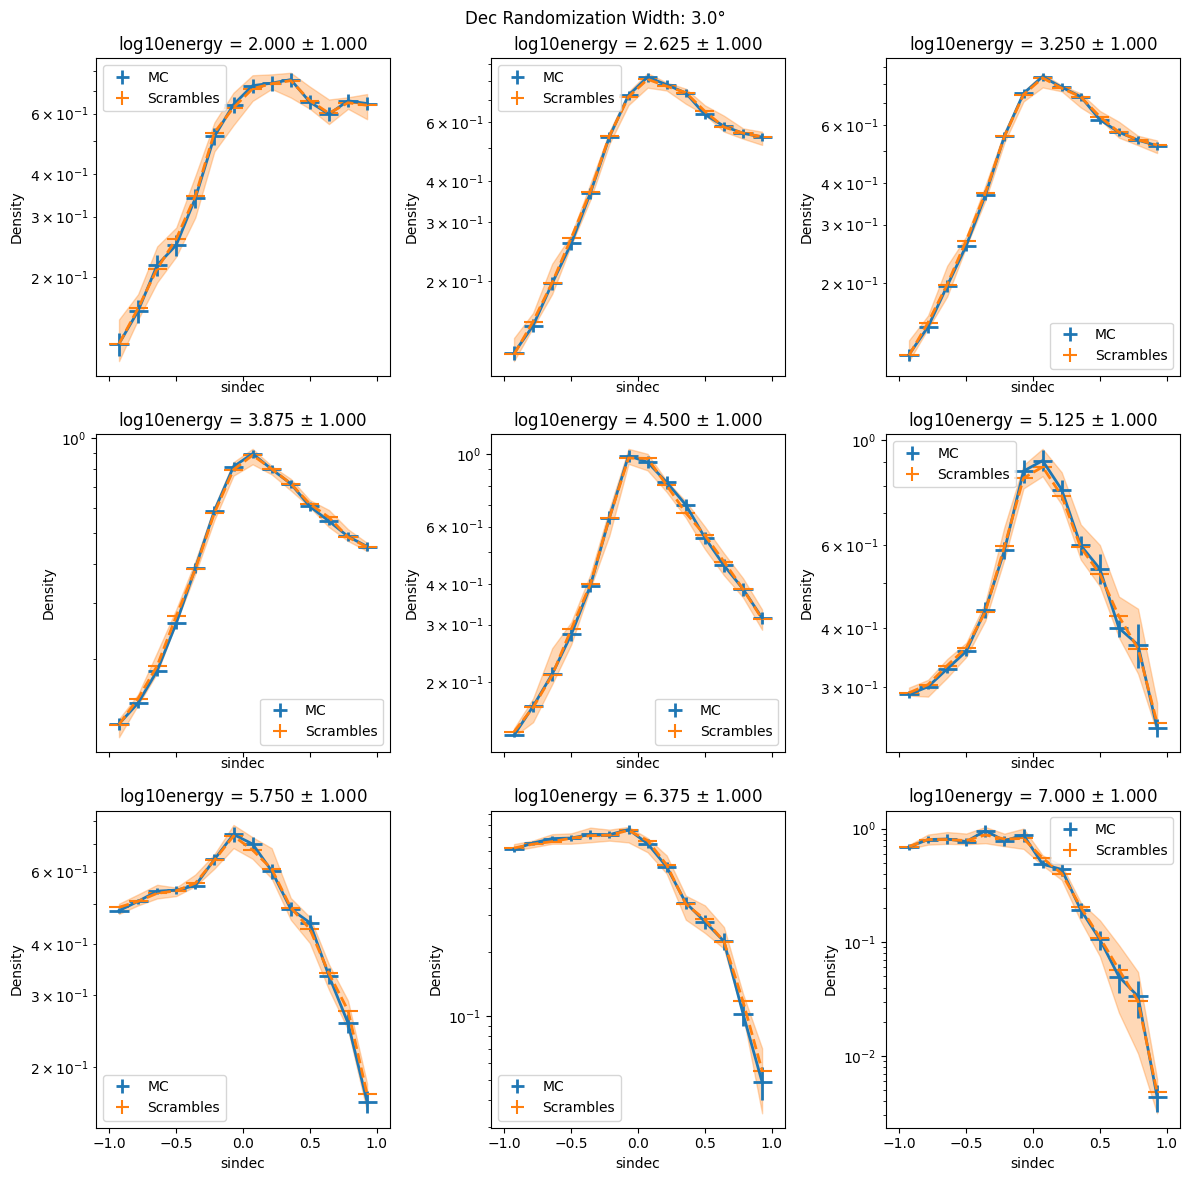

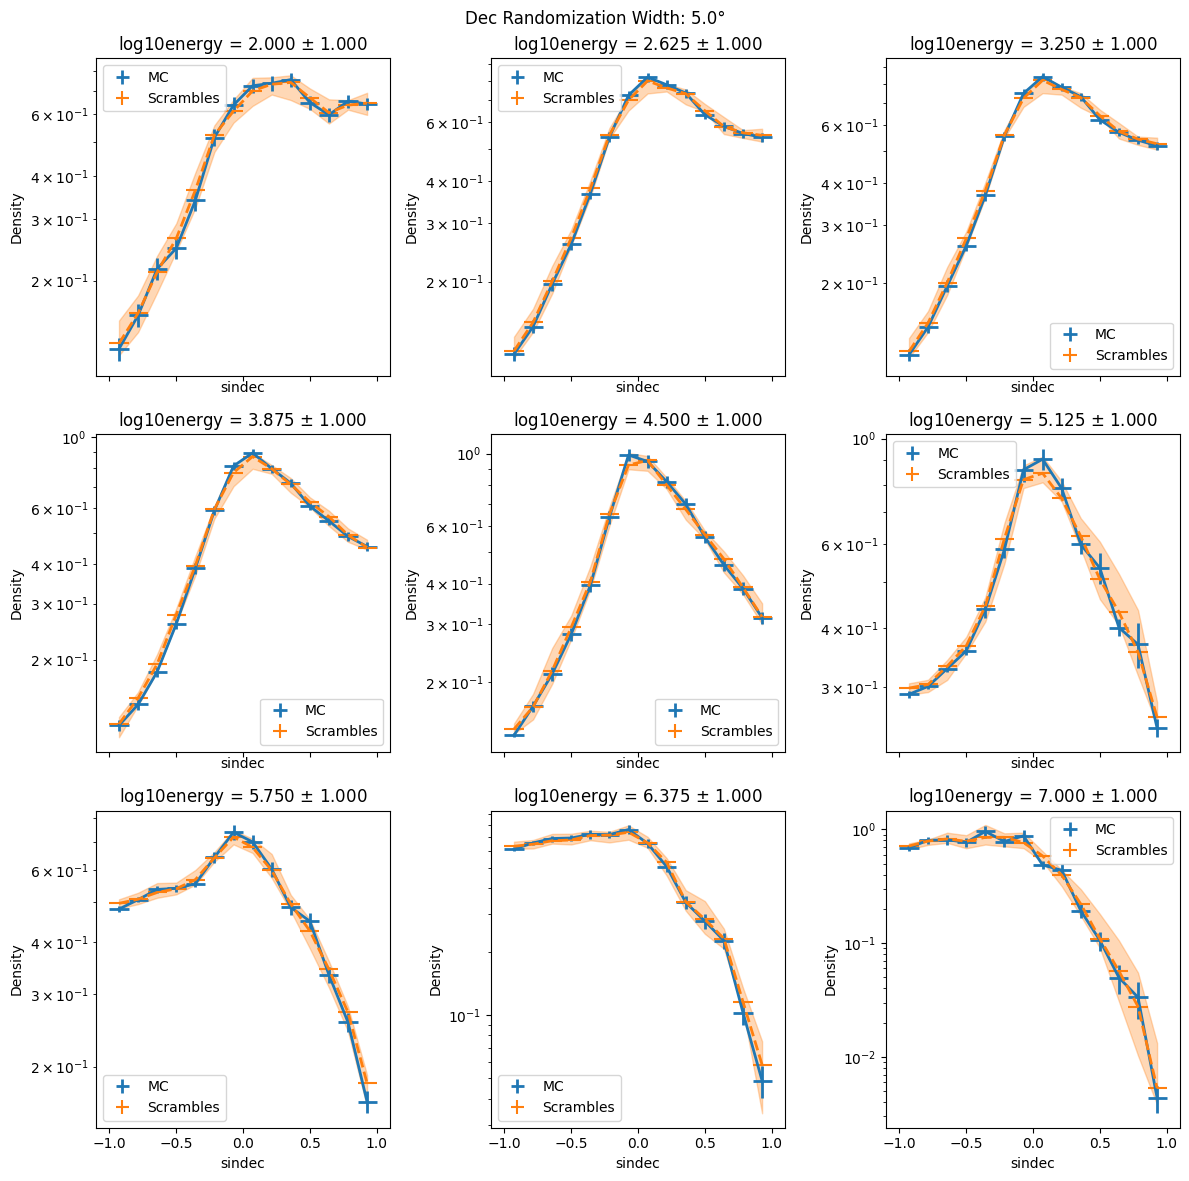

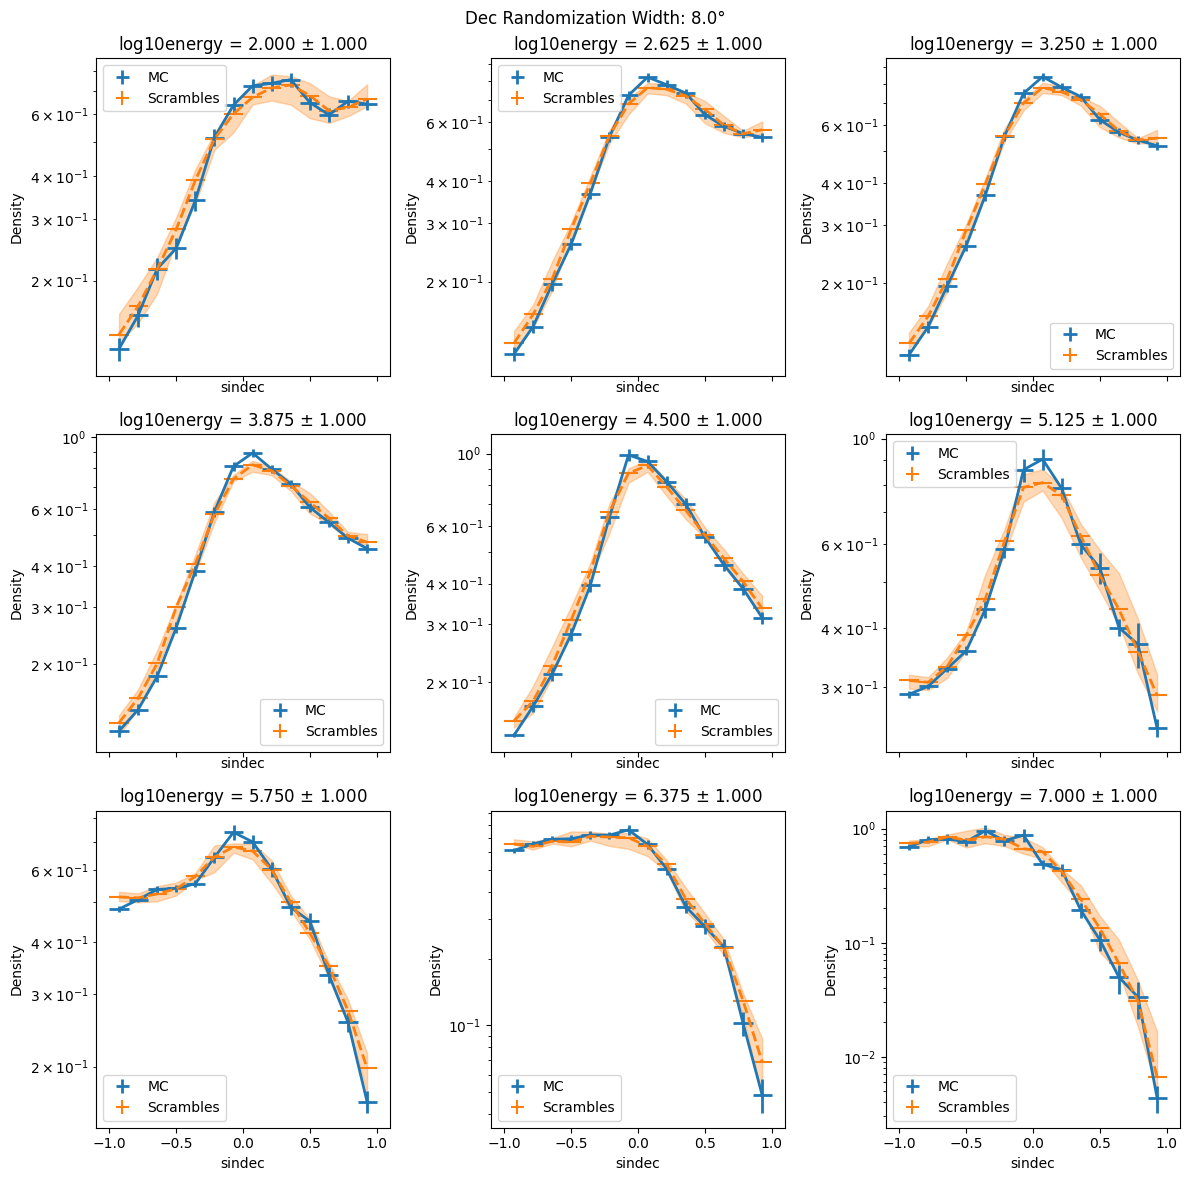

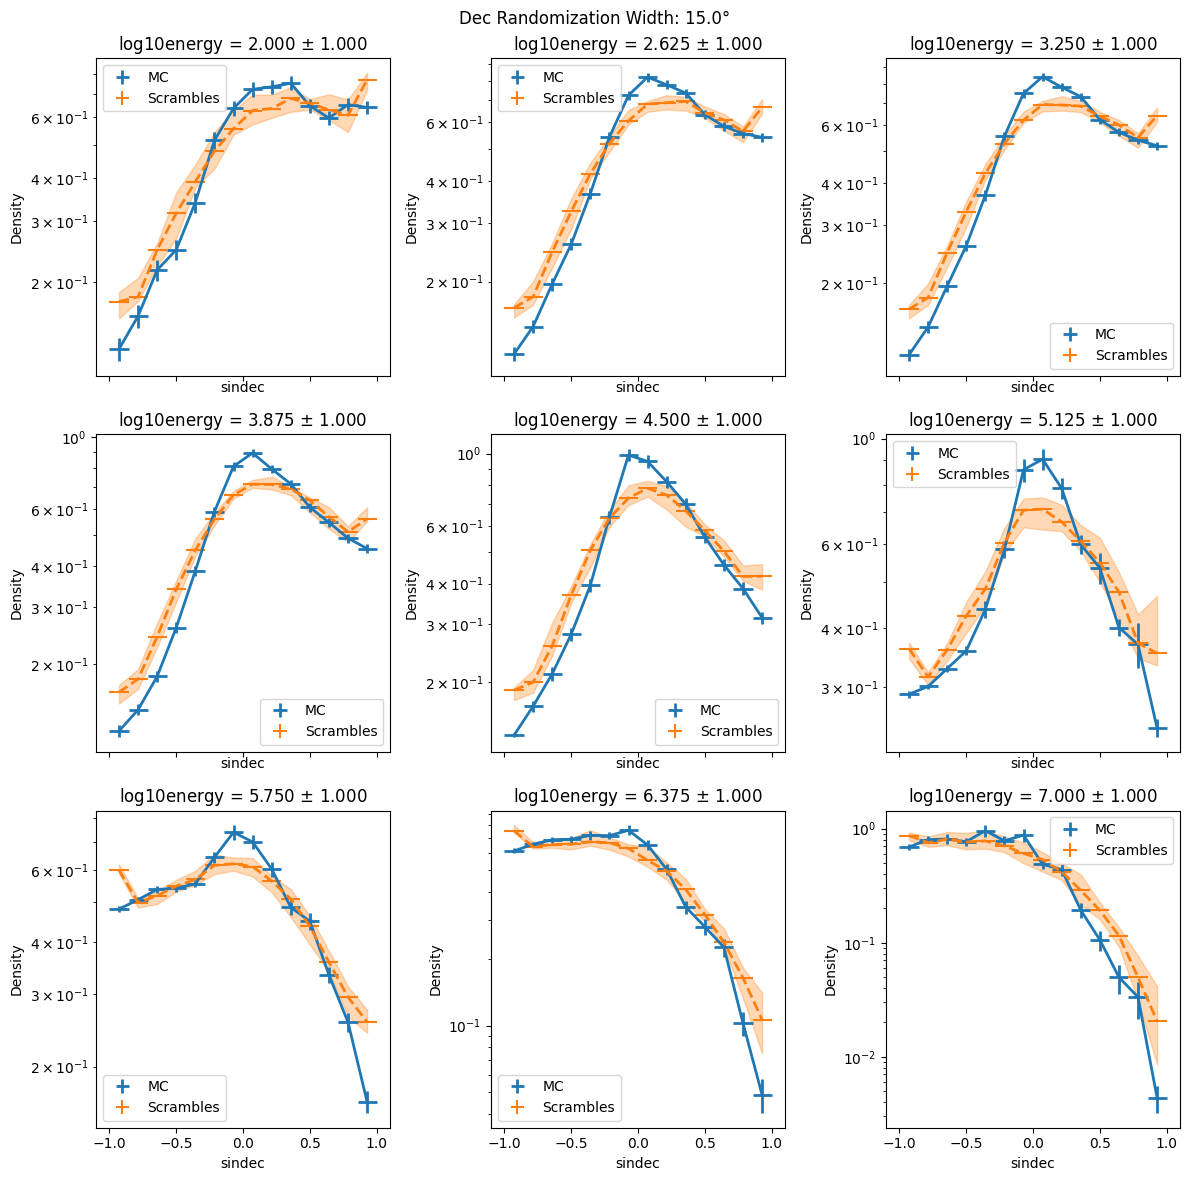

In [15]:
for sig in [True, False]:
    for rand_width in rand_widths:
        fig, axes = plot_scramble_distribution(
            key='sindec', 
            key_cond='log10energy',
            bins=np.linspace(-1, 1, 15),
            cond_mids=np.linspace(2, 7, 9),
            cond_width=1.,
            conf_kwargs=get_conf(randomization_width=rand_width),
            sig=sig,
        )
        fig.suptitle('Dec Randomization Width: {:3.1f}°'.format(np.rad2deg(rand_width)))
        fig.tight_layout()
        fig.savefig(os.path.join(plot_dir, 'scramble_dist_sindec_log10energy_{}_width_{:3.1f}.png'.format(sig, np.rad2deg(rand_width))))


##### Sigma-Mask

/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


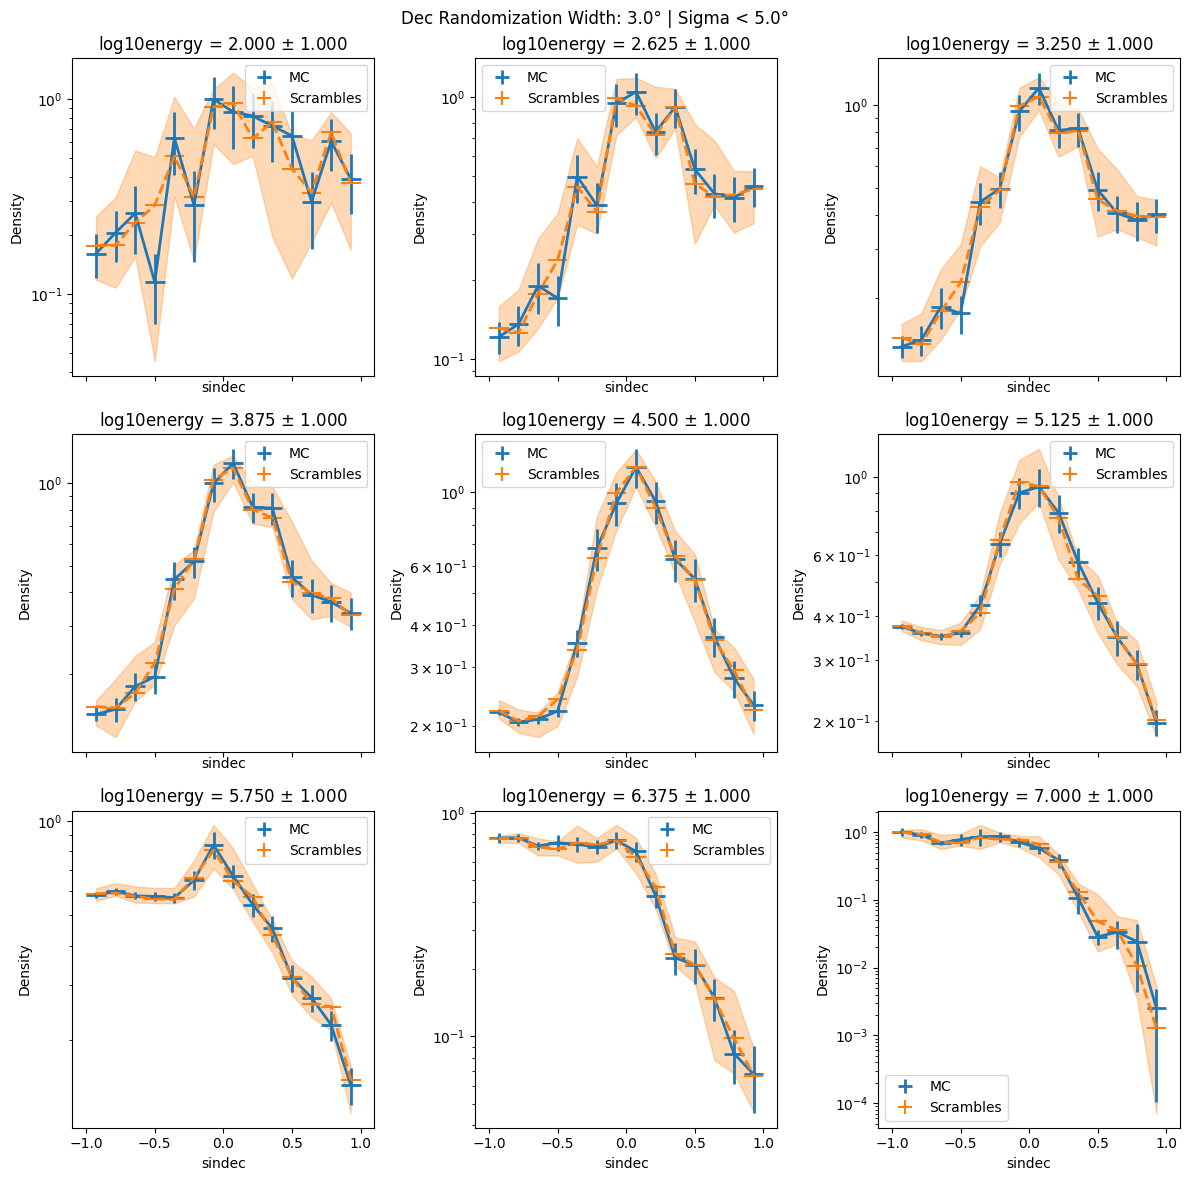

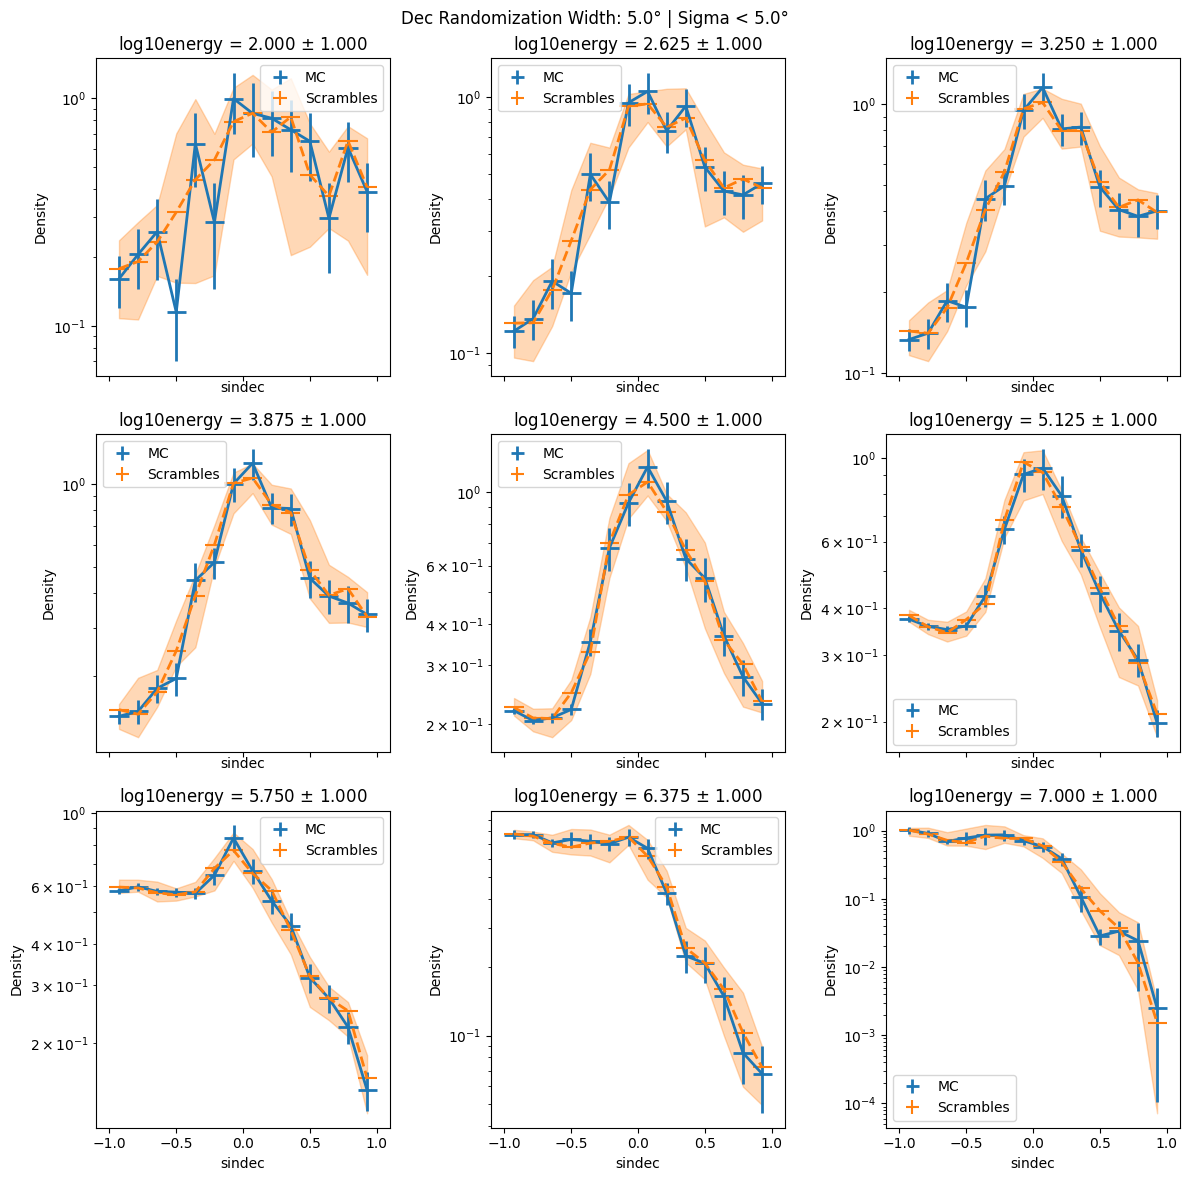

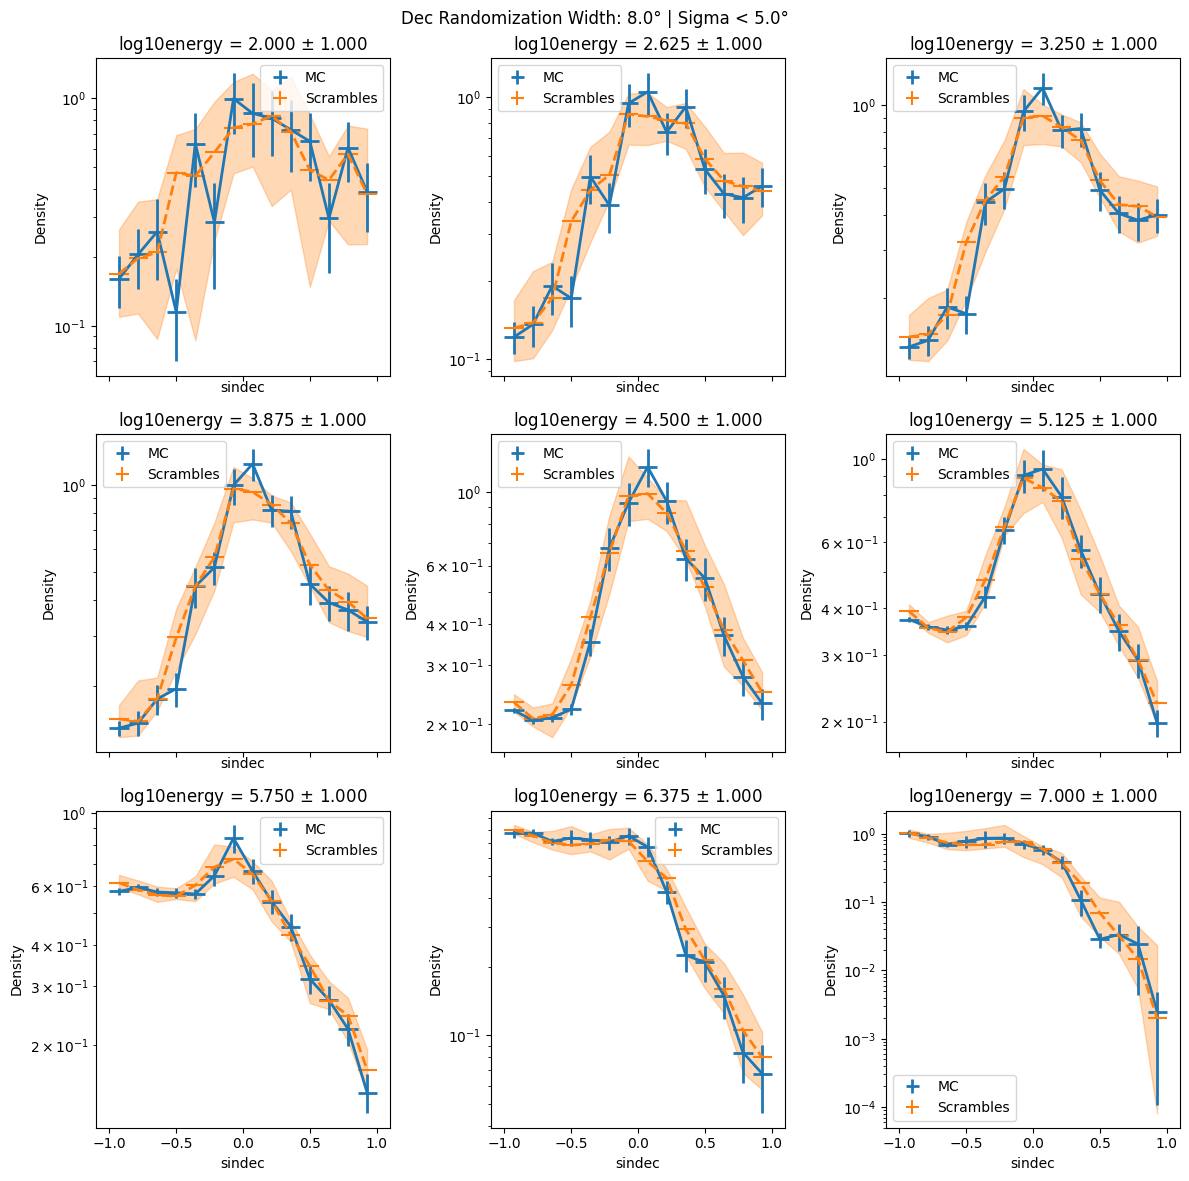

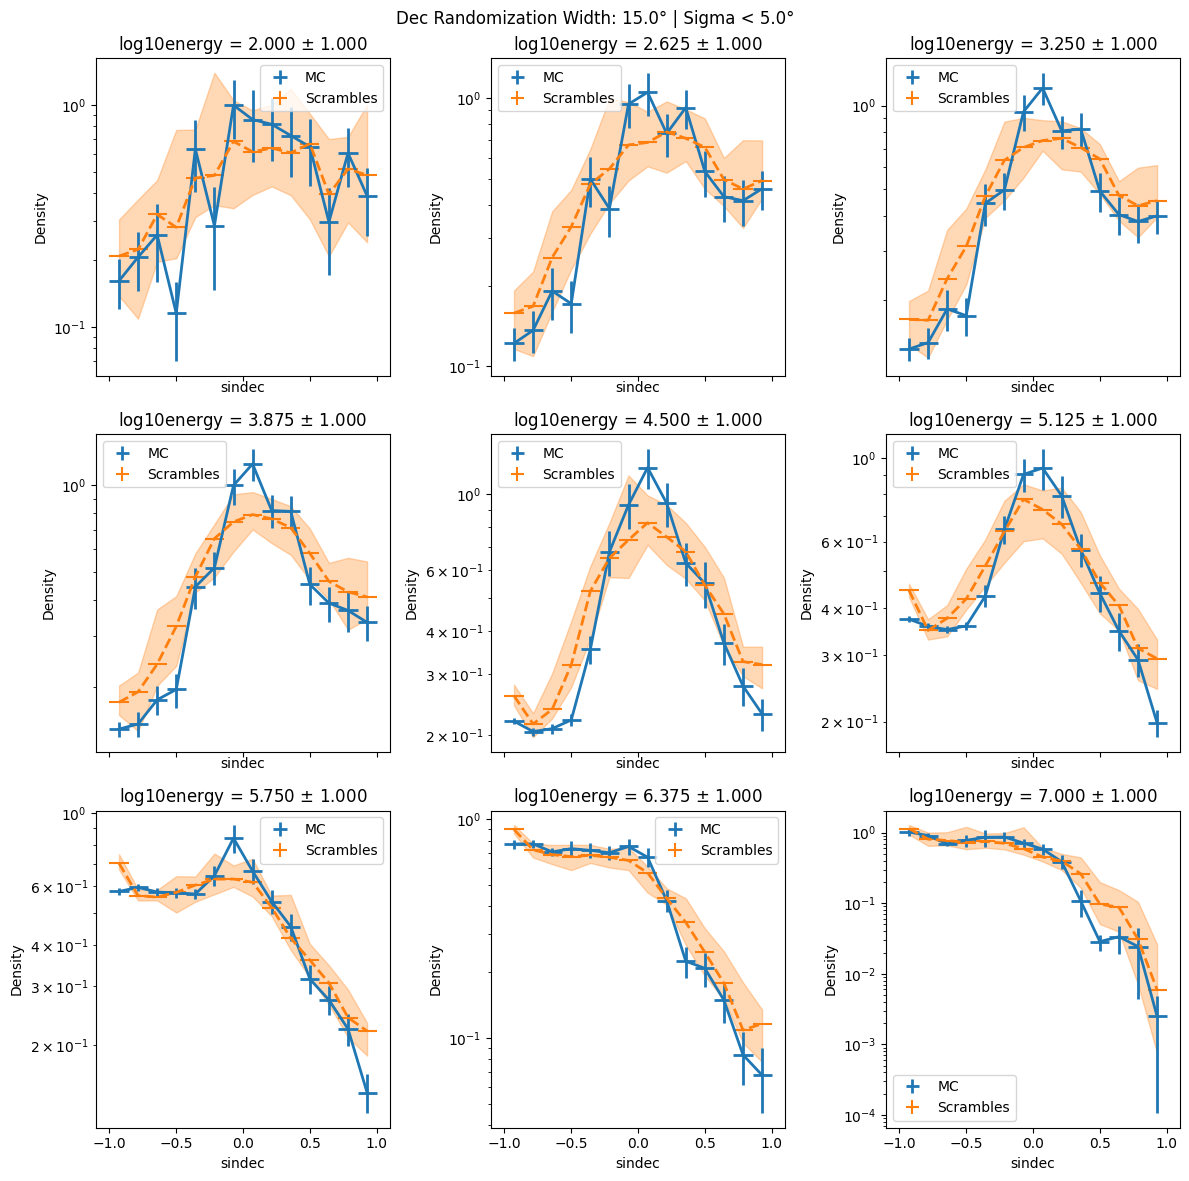

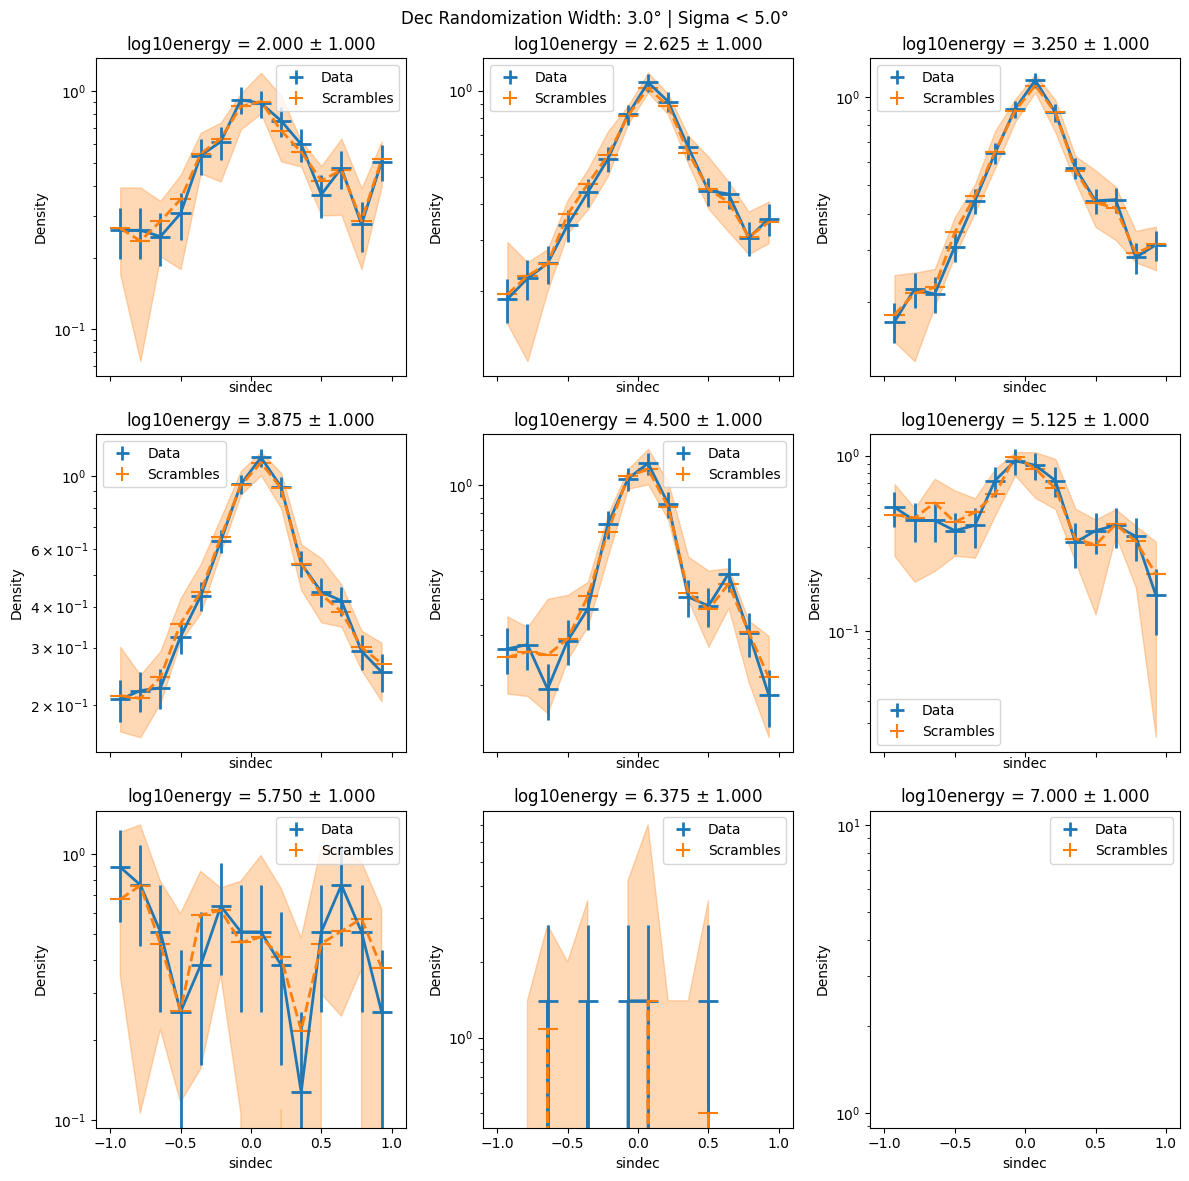

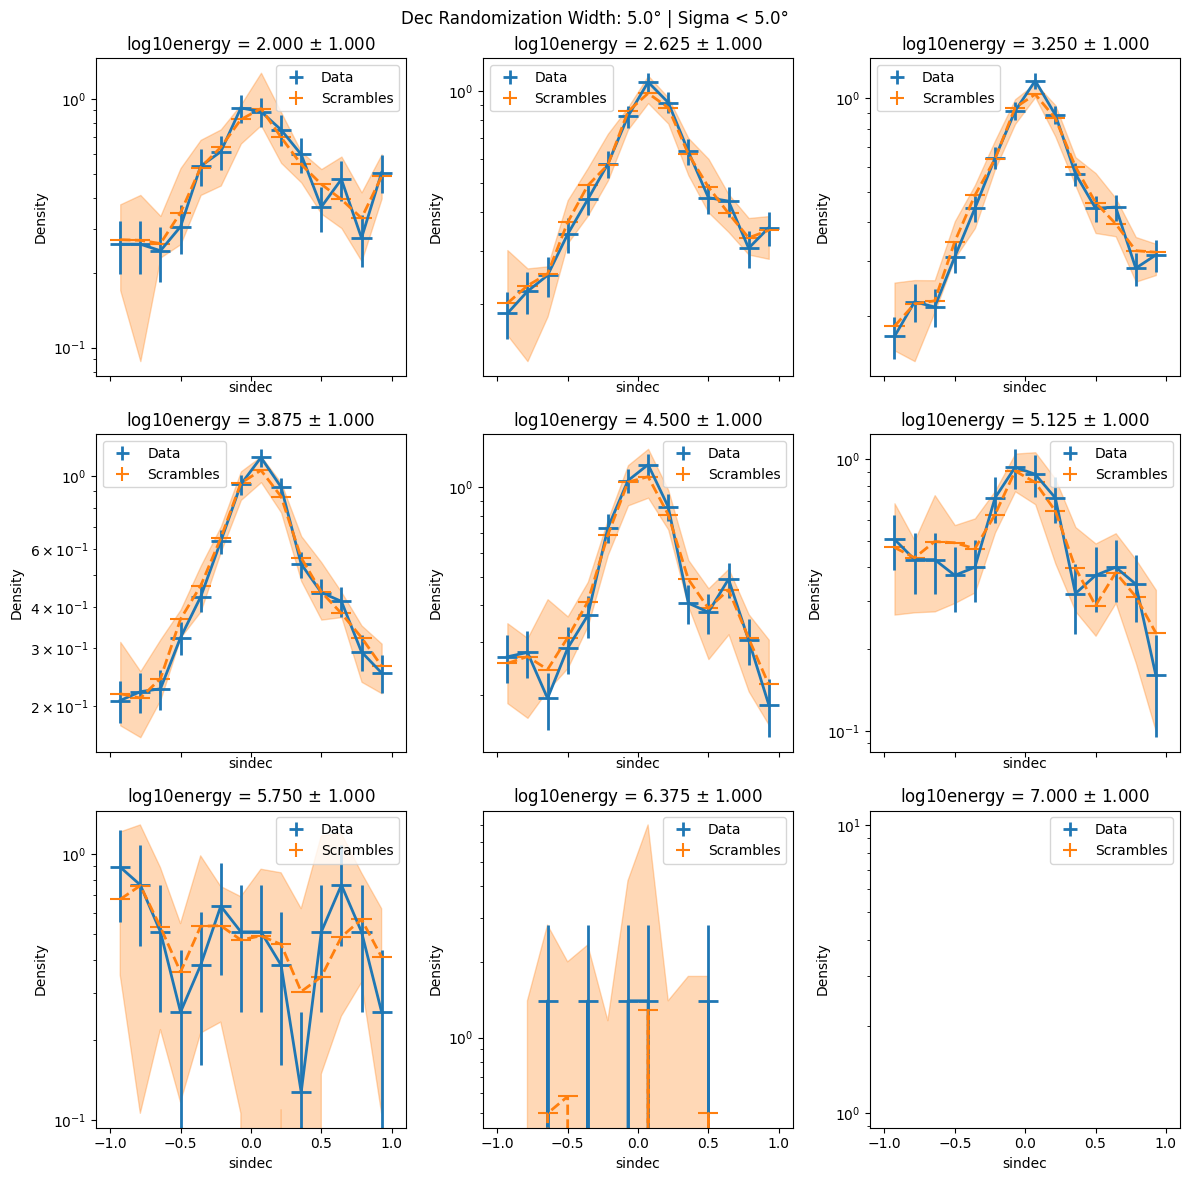

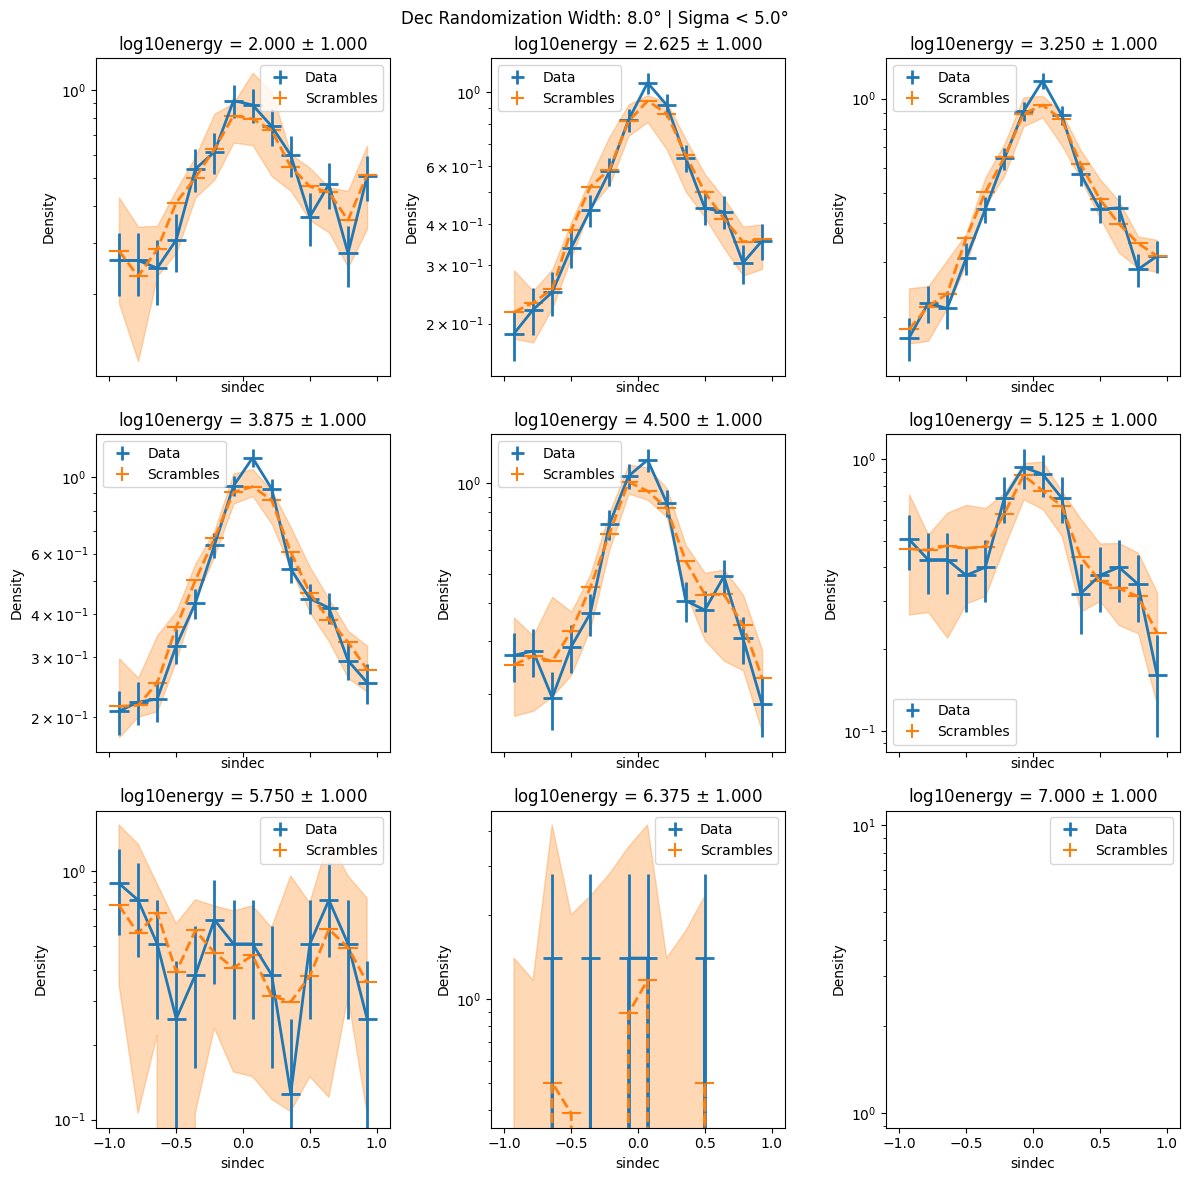

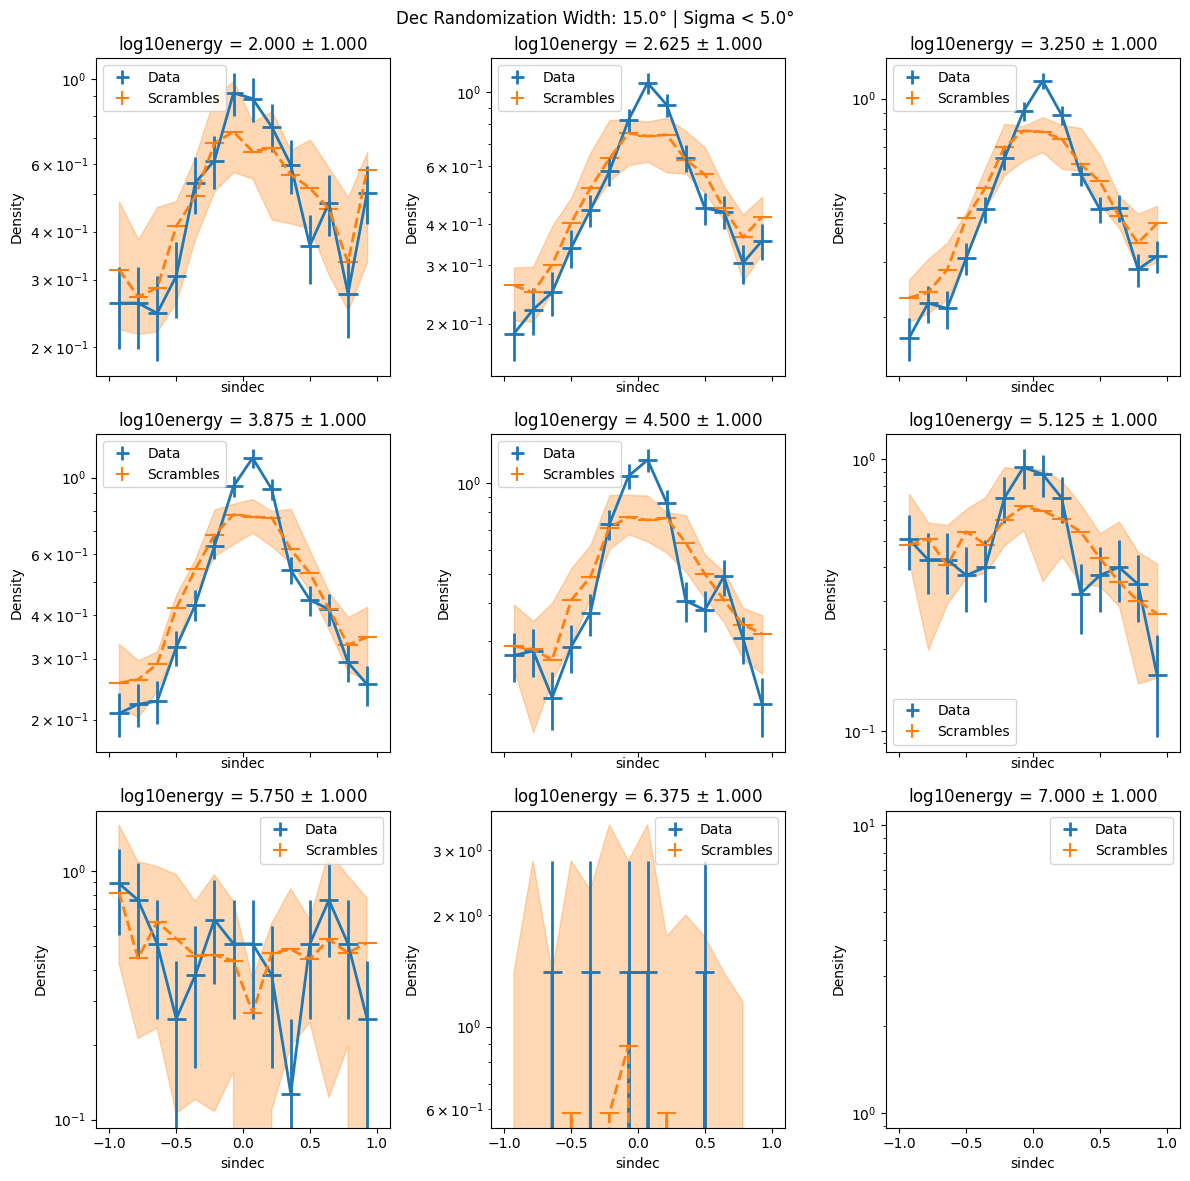

In [32]:
max_sigma_deg = 5
def mask_func(df):
    return df.sigma < np.deg2rad(max_sigma_deg)

for sig in [True, False]:
    for rand_width in rand_widths:
        fig, axes = plot_scramble_distribution(
            key='sindec', 
            key_cond='log10energy',
            bins=np.linspace(-1, 1, 15),
            cond_mids=np.linspace(2, 7, 9),
            cond_width=1.,
            conf_kwargs=get_conf(randomization_width=rand_width),
            sig=sig,
            mask_func=mask_func,
        )
        fig.suptitle('Dec Randomization Width: {:3.1f}° | Sigma < {:3.1f}°'.format(np.rad2deg(rand_width), max_sigma_deg))
        fig.tight_layout()
        fig.savefig(os.path.join(plot_dir, 'scramble_dist_sindec_log10energy_{}_width_{:3.1f}__sigma_less_{:3.1f}.png'.format(sig, np.rad2deg(rand_width), max_sigma_deg)))


#### SindecJitter

In [24]:
sindec_jitters = [0.01, 0.03, 0.05, 0.10]

/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100
cut_n_sigma: 100


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


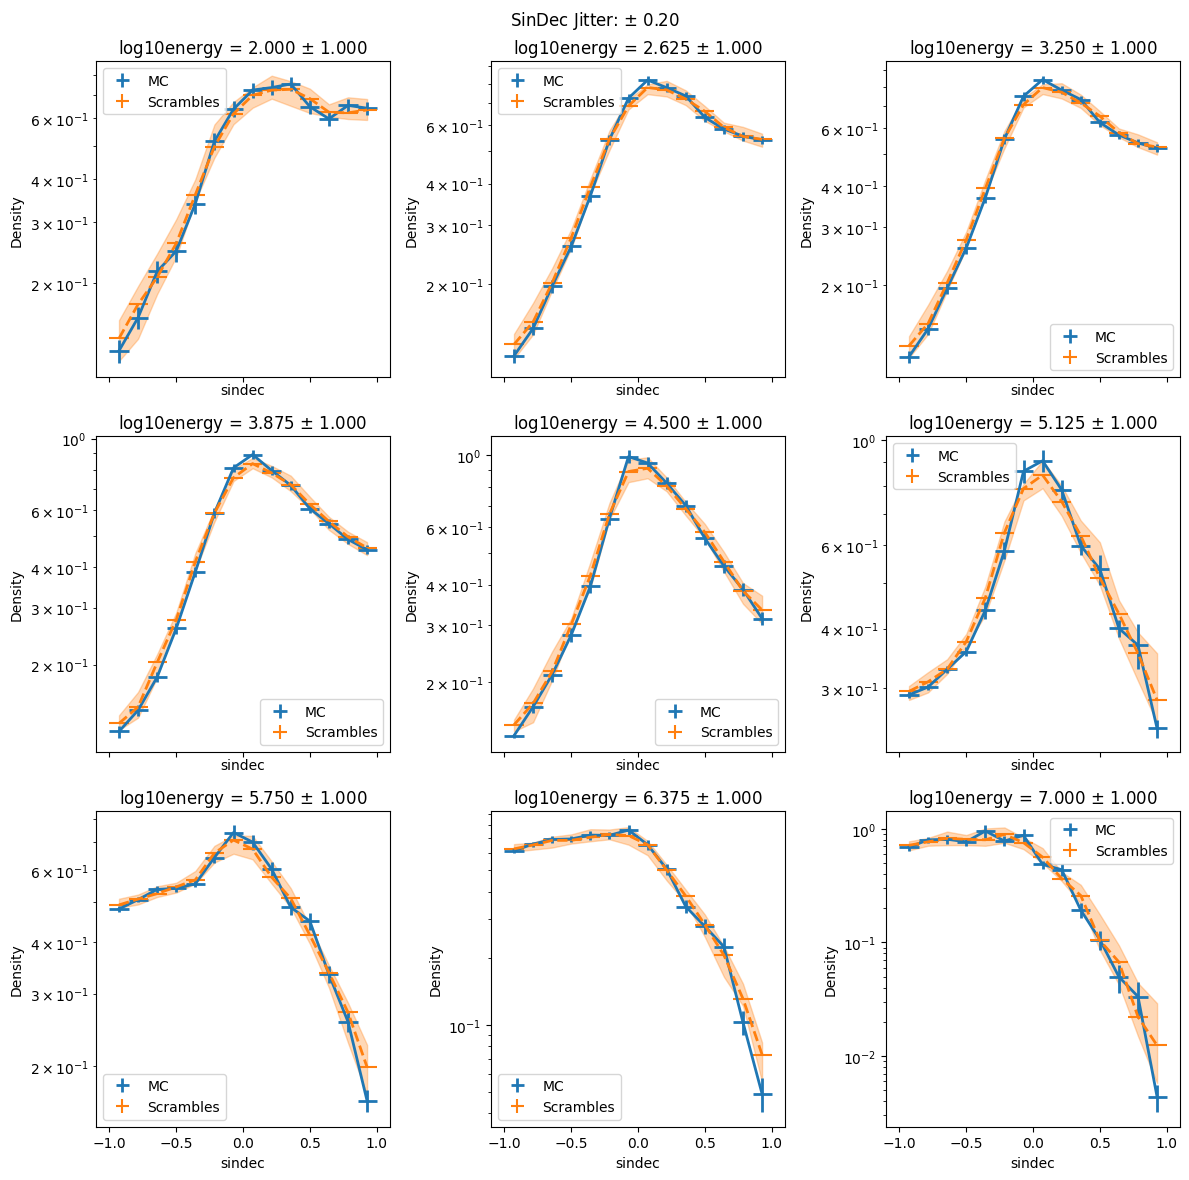

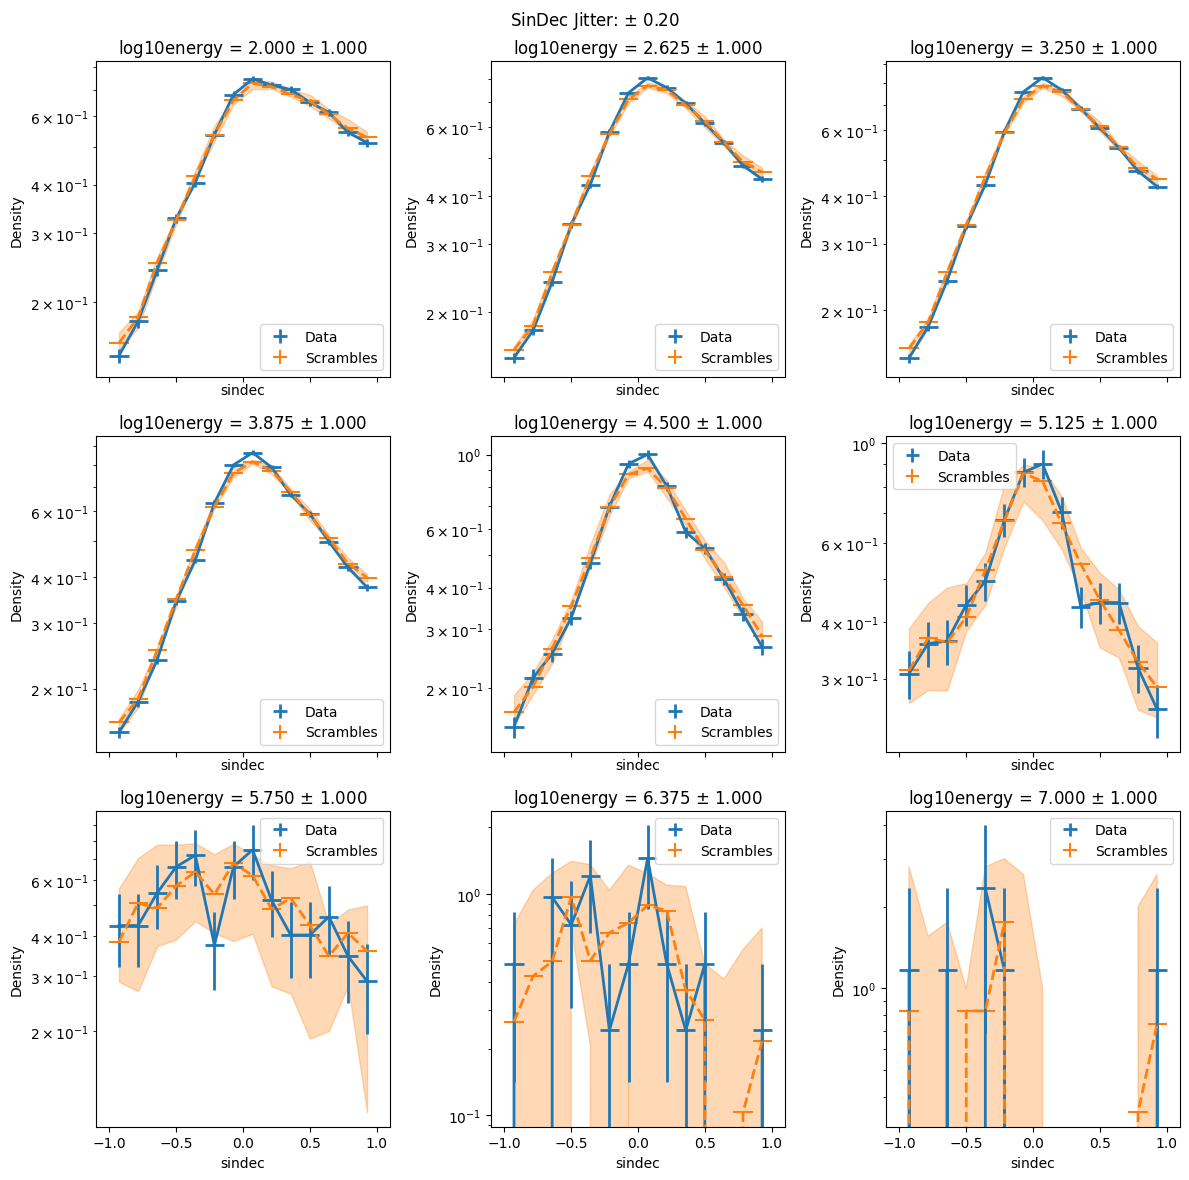

In [25]:
for sig in [True, False]:
    for sindec_jitter in sindec_jitters:
        fig, axes = plot_scramble_distribution(
            key='sindec', 
            key_cond='log10energy',
            bins=np.linspace(-1, 1, 15),
            cond_mids=np.linspace(2, 7, 9),
            cond_width=1.,
            conf_kwargs=dict(sindec_jitter=sindec_jitter),
            sig=sig,
            tr_func=get_trial_runner_sindec_jitter,
        )
        fig.suptitle('SinDec Jitter: $\pm$ {:3.2f}'.format(sindec_jitter))
        fig.tight_layout()
        fig.savefig(os.path.join(plot_dir, 'scramble_dist_sindec_log10energy_{}_jitter_{:3.2f}.png'.format(sig, sindec_jitter)))
